In [50]:
#Install dependencies
#%pip install statsmodels
#%pip install matplotlib
#%pip install pandas
#%pip install seaborn


#Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

# Exploratory Data Analysis

In [1]:
# Consolidated imports for the entire notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data and perform basic checks
data = pd.read_csv("dataset.csv")

# Convert date to datetime format
try:
    data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
    print(f"Data spans from {data['Date'].min()} to {data['Date'].max()}")
    # Add day of week info
    data['day_of_week'] = data['Date'].dt.day_name()
    data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday'])
except Exception as e:
    print(f"Could not process Date column: {e}")

# Display basic dataset info
print(f"\nDataset shape: {data.shape}")
print(f"Columns: {', '.join(data.columns)}")
display(data.head())

# Identify asset types
crypto_cols = [col for col in data.columns if 'USD' in col and col != 'Date']
trad_cols = [col for col in data.columns if 'USD' not in col and col not in ['Date', 'day_of_week', 'is_weekend']]

print(f"\nCrypto assets ({len(crypto_cols)}): {', '.join(crypto_cols)}")
print(f"Traditional assets ({len(trad_cols)}): {', '.join(trad_cols)}")

Data spans from 2017-10-01 00:00:00 to 2025-03-20 00:00:00

Dataset shape: (2728, 17)
Columns: Date, ADA-USD, BCH-USD, BTC-USD, DOGE-USD, ETH-USD, LINK-USD, LTC-USD, MANA-USD, XLM-USD, XRP-USD, SPXT, XCMP, SOFR, VIX, day_of_week, is_weekend


,Date,ADA-USD,BCH-USD,BTC-USD,DOGE-USD,ETH-USD,LINK-USD,LTC-USD,MANA-USD,XLM-USD,XRP-USD,SPXT,XCMP,SOFR,VIX,day_of_week,is_weekend
0,2017-10-01,0.02519,416.40,4403.09,0.001076,303.95,0.4365,54.80,0.01817,0.01387,0.2083,4887.97,7447.572790,0.993372,9.51,Sunday,True
1,2017-10-02,0.02588,419.84,4401.32,0.001051,296.81,0.3574,53.29,0.01448,0.01300,0.2031,4906.92,7471.384512,0.993401,9.45,Monday,False
2,2017-10-03,0.02084,402.17,4314.18,0.001023,291.81,0.3455,52.15,0.01689,0.01241,0.2033,4917.73,7489.156529,0.993432,9.51,Tuesday,False
3,2017-10-04,0.02189,355.84,4218.66,0.001014,291.68,0.3920,51.22,0.01445,0.01181,0.2135,4924.19,7493.646686,0.993464,9.63,Wednesday,False
4,2017-10-05,0.02152,354.36,4321.44,0.001007,294.99,0.4050,51.64,0.01353,0.01449,0.2380,4952.85,7551.916900,0.993496,9.19,Thursday,False



Crypto assets (10): ADA-USD, BCH-USD, BTC-USD, DOGE-USD, ETH-USD, LINK-USD, LTC-USD, MANA-USD, XLM-USD, XRP-USD
Traditional assets (4): SPXT, XCMP, SOFR, VIX


## Linear vs Log Returns: Theoretical Framework

In financial analysis, we can express asset returns in two primary ways:

1. **Linear (Simple) Returns**: $r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$
2. **Logarithmic (Continuously Compounded) Returns**: $r_t = \log(\frac{P_t}{P_{t-1}})$

According to Meucci (2010), the choice between these return types depends on several factors:

- **Time additivity**: Log returns are additive across time (multi-period returns are sums of single-period returns)
- **Cross-sectional additivity**: Linear returns are additive across assets (portfolio returns are weighted sums of asset returns)
- **Statistical properties**: Log returns often have more desirable statistical properties (closer to normal distribution)
- **Magnitude of returns**: For small returns (<10%), the difference is negligible; for larger returns (typical in crypto), the difference becomes significant

For cryptocurrencies specifically, we need to consider their **marginal distributions** - high volatility and heavy tails suggest log returns may be more appropriate as they:

1. Better handle the large price swings common in crypto markets
2. Prevent return skewness from affecting analysis (log returns are more symmetric)
3. Facilitate time series modeling by improving normality assumptions

Let's calculate both return types and examine their properties before making a decision.

In [3]:
assets = crypto_cols + trad_cols

returns_df = data.copy()
# Add columns for returns and log returns
for col in assets:
    returns_df[f'{col}_returns'] = returns_df[col].pct_change()
    returns_df[f'{col}_log_returns'] = np.log(returns_df[col] / returns_df[col].shift(1))
# Drop NaN values
returns_df.dropna(inplace=True)
# Display the first few rows of the returns DataFrame
display(returns_df.head())
    

,Date,ADA-USD,BCH-USD,BTC-USD,DOGE-USD,ETH-USD,LINK-USD,LTC-USD,MANA-USD,XLM-USD,...,XRP-USD_returns,XRP-USD_log_returns,SPXT_returns,SPXT_log_returns,XCMP_returns,XCMP_log_returns,SOFR_returns,SOFR_log_returns,VIX_returns,VIX_log_returns
1,2017-10-02,0.02588,419.84,4401.32,0.001051,296.81,0.3574,53.29,0.01448,0.01300,...,-0.024964,-0.025281,0.003877,0.003869,0.003197,0.003192,0.000029,0.000029,-0.006309,-0.006329
2,2017-10-03,0.02084,402.17,4314.18,0.001023,291.81,0.3455,52.15,0.01689,0.01241,...,0.000985,0.000984,0.002203,0.002201,0.002379,0.002376,0.000032,0.000032,0.006349,0.006329
3,2017-10-04,0.02189,355.84,4218.66,0.001014,291.68,0.3920,51.22,0.01445,0.01181,...,0.050172,0.048954,0.001314,0.001313,0.000600,0.000599,0.000032,0.000032,0.012618,0.012539
4,2017-10-05,0.02152,354.36,4321.44,0.001007,294.99,0.4050,51.64,0.01353,0.01449,...,0.114754,0.108634,0.005820,0.005803,0.007776,0.007746,0.000032,0.000032,-0.045691,-0.046767
5,2017-10-06,0.01849,363.35,4371.94,0.001024,308.33,0.4680,52.08,0.00814,0.01838,...,-0.019328,-0.019517,-0.000759,-0.000759,0.000747,0.000747,0.000032,0.000032,0.050054,0.048842


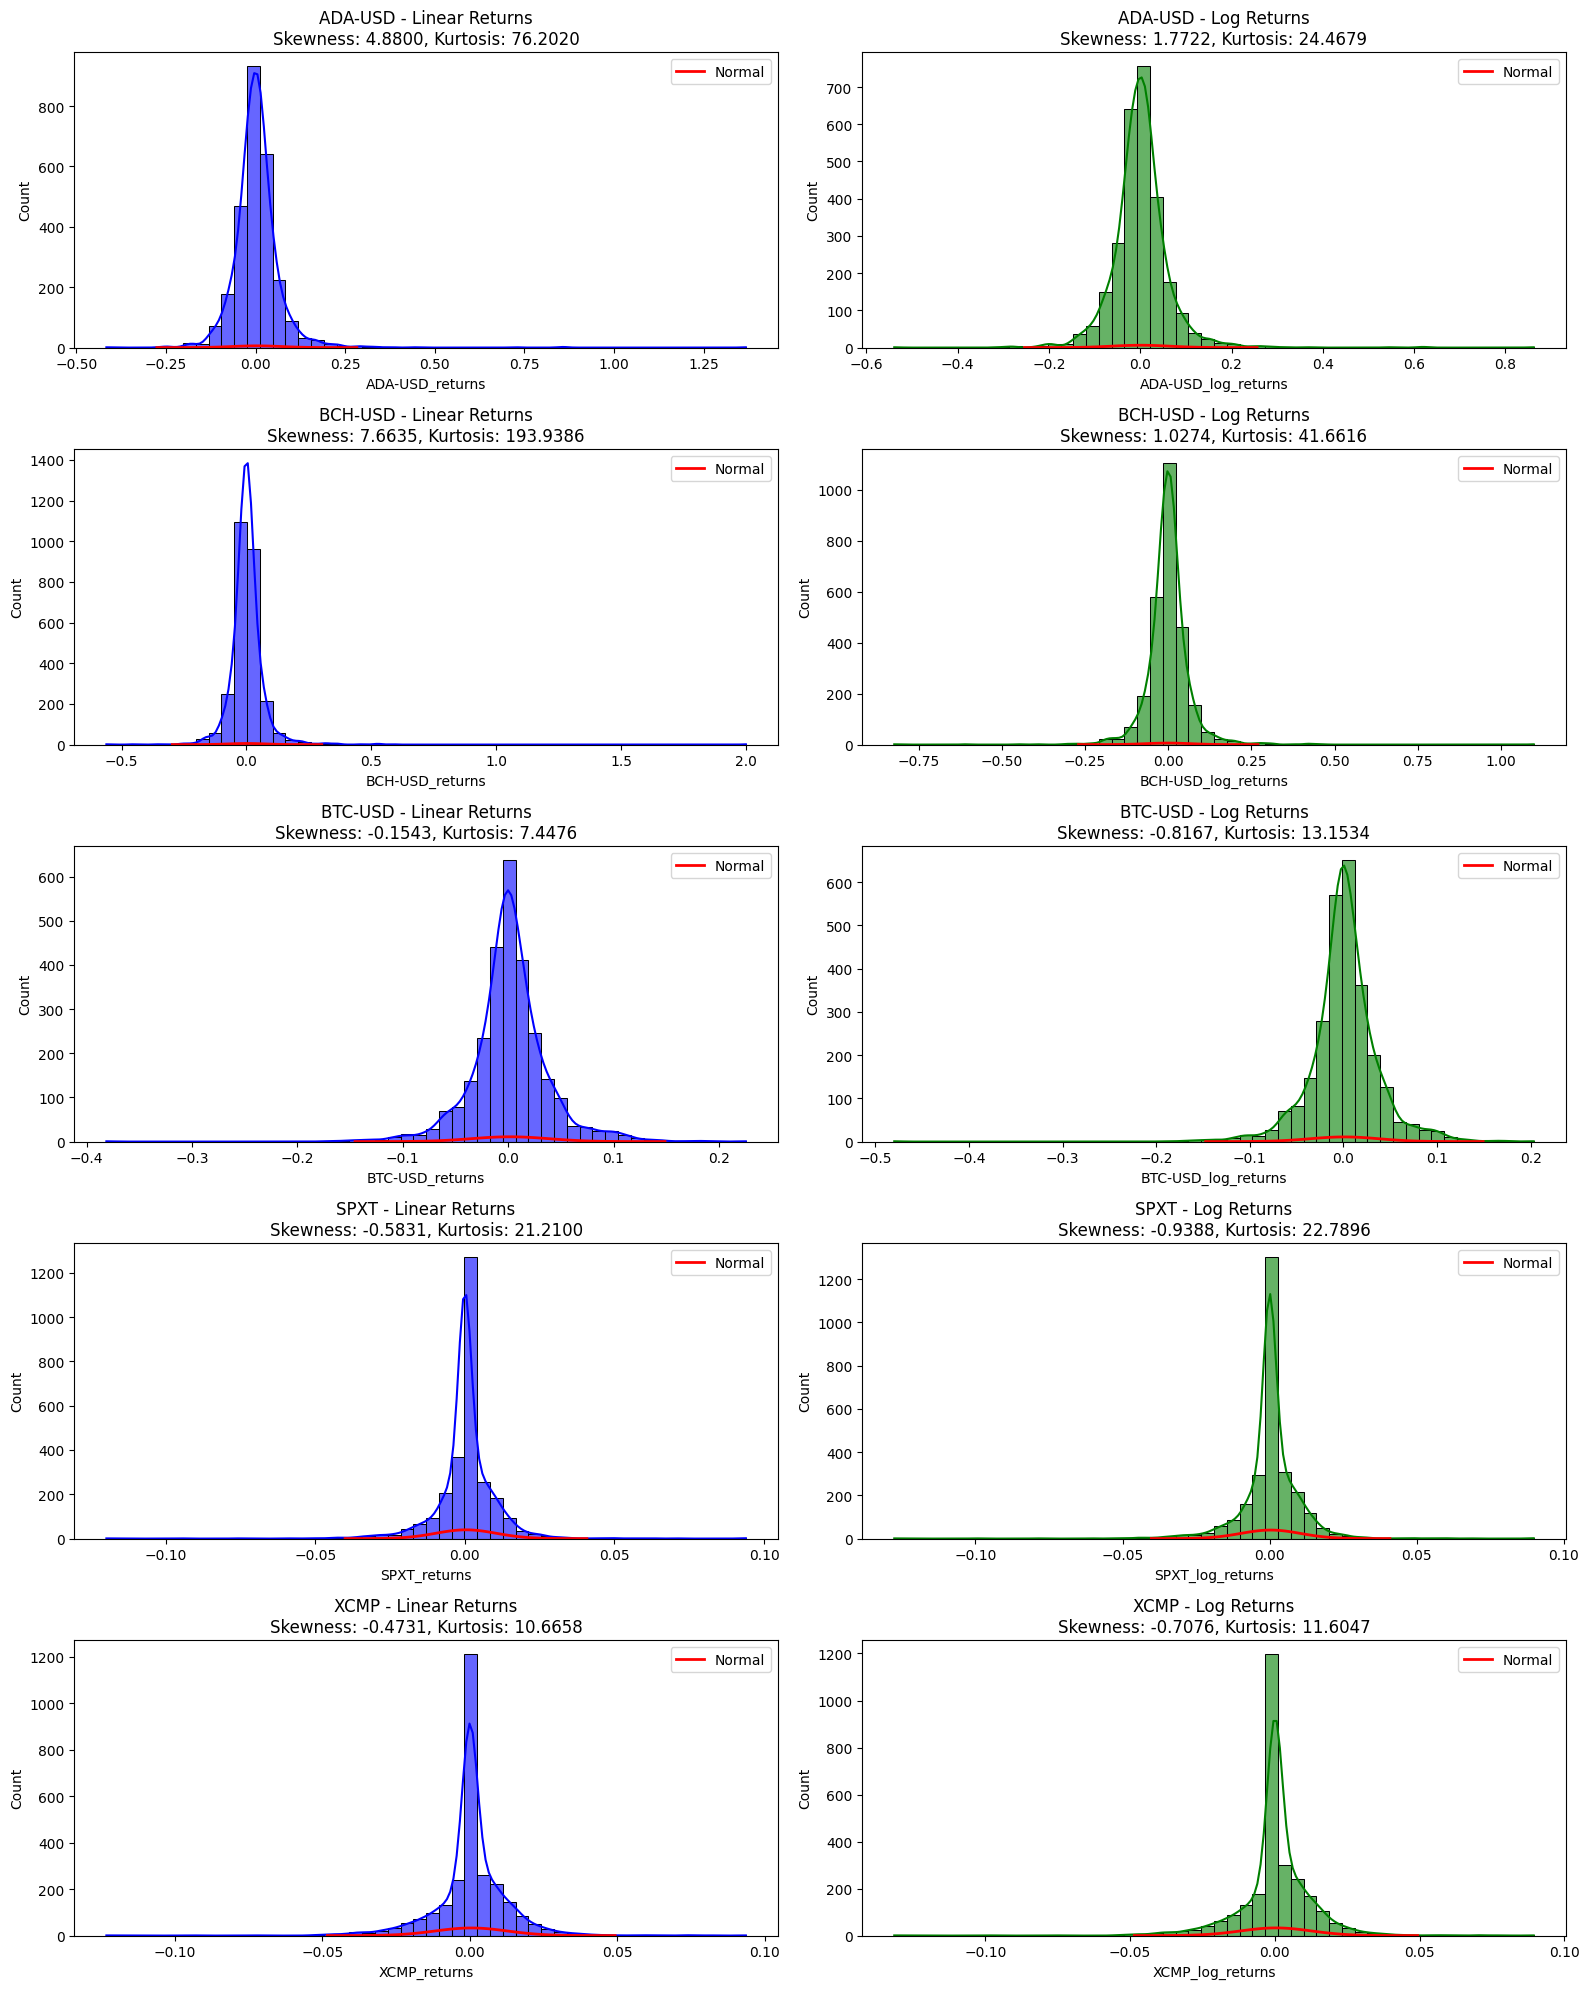

Statistical properties comparing linear vs. log returns:


,Linear_Skew,Log_Skew,Linear_Kurt,Log_Kurt,Linear_Normal_p,Log_Normal_p
ADA-USD,4.880001,1.772220,76.202017,24.467924,1.942963e-53,9.138499e-45
BCH-USD,7.663496,1.027413,193.938618,41.661628,3.273064e-58,2.660467e-50
BTC-USD,-0.154349,-0.816670,7.447621,13.153364,1.437580e-34,7.280026e-37
SPXT,-0.583058,-0.938764,21.209966,22.789570,2.568844e-50,1.248306e-50
XCMP,-0.473088,-0.707616,10.665785,11.604672,1.346210e-44,5.574420e-45


In [4]:
# Select a smaller subset of assets for visualization (to reduce output size)
selected_assets = crypto_cols[:3] + trad_cols[:2] if len(crypto_cols) >= 3 and len(trad_cols) >= 2 else assets[:5]

# Create a summary dataframe for statistical comparison
stats_df = pd.DataFrame()

fig, axes = plt.subplots(len(selected_assets), 2, figsize=(16, 4*len(selected_assets)))

for i, asset in enumerate(selected_assets):
    # Calculate statistics
    stats_df.loc[asset, 'Linear_Skew'] = returns_df[f"{asset}_returns"].skew()
    stats_df.loc[asset, 'Log_Skew'] = returns_df[f"{asset}_log_returns"].skew()
    stats_df.loc[asset, 'Linear_Kurt'] = returns_df[f"{asset}_returns"].kurtosis()
    stats_df.loc[asset, 'Log_Kurt'] = returns_df[f"{asset}_log_returns"].kurtosis()
    
    # Test for normality (p-value from Shapiro-Wilk test)
    stats_df.loc[asset, 'Linear_Normal_p'] = stats.shapiro(returns_df[f"{asset}_returns"].dropna())[1]
    stats_df.loc[asset, 'Log_Normal_p'] = stats.shapiro(returns_df[f"{asset}_log_returns"].dropna())[1]
    
    # Linear returns visualization
    ax = axes[i, 0]
    sns.histplot(returns_df[f"{asset}_returns"], kde=True, ax=ax, bins=50, color='blue', alpha=0.6)
    
    # Add normal distribution for comparison
    mu, sigma = returns_df[f"{asset}_returns"].mean(), returns_df[f"{asset}_returns"].std()
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Normal')
    
    ax.set_title(f"{asset} - Linear Returns\nSkewness: {stats_df.loc[asset, 'Linear_Skew']:.4f}, "
                 f"Kurtosis: {stats_df.loc[asset, 'Linear_Kurt']:.4f}")
    ax.legend()
    
    # Log returns visualization
    ax = axes[i, 1]
    sns.histplot(returns_df[f"{asset}_log_returns"], kde=True, ax=ax, bins=50, color='green', alpha=0.6)
    
    # Add normal distribution for comparison
    mu, sigma = returns_df[f"{asset}_log_returns"].mean(), returns_df[f"{asset}_log_returns"].std()
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Normal')
    
    ax.set_title(f"{asset} - Log Returns\nSkewness: {stats_df.loc[asset, 'Log_Skew']:.4f}, "
                 f"Kurtosis: {stats_df.loc[asset, 'Log_Kurt']:.4f}")
    ax.legend()

plt.tight_layout()
plt.show()

print("Statistical properties comparing linear vs. log returns:")
display(stats_df)

## Testing for Independence: Autocorrelation Analysis

For financial time series modeling, we often assume returns are independent and identically distributed (IID). The independence assumption is critical for many statistical methods and suggests that past returns cannot predict future returns (weak-form market efficiency).

To test if returns are independent, we can analyze the **autocorrelation function (ACF)**, which measures the correlation between a time series and its lagged values. If returns are truly independent, the autocorrelations should be close to zero for all lags (except lag 0).

Key tools for testing independence:
1. **ACF plot**: Visual inspection of autocorrelations at different lags
2. **Ljung-Box test**: Statistical test for the presence of autocorrelation
3. **Box-Pierce test**: Similar to Ljung-Box but less powerful for small samples

Let's implement these tests for both linear and log returns to assess which better satisfies the independence assumption.

In [16]:
# Testing for autocorrelation in returns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to analyze autocorrelation
def analyze_autocorrelation(returns, asset_name, lags=20):
    """Analyze autocorrelation in returns, including ACF plot and Ljung-Box test"""
    # Perform Ljung-Box test (tests the null hypothesis of no autocorrelation)
    lb_test = acorr_ljungbox(returns, lags=[lags])
    lb_stat = lb_test.iloc[0, 0]
    lb_pvalue = lb_test.iloc[0, 1]
    
    # Get ACF values
    acf = sm.tsa.acf(returns, nlags=lags, fft=True)
    
    # Compute critical value for 95% confidence
    critical_value = 1.96 / np.sqrt(len(returns))
    
    # Count significant lags
    significant_lags = sum(np.abs(acf[1:]) > critical_value)  # Exclude lag 0
    
    return {
        'asset': asset_name,
        'ljung_box_stat': lb_stat,
        'ljung_box_pvalue': lb_pvalue,
        'significant_lags': significant_lags,
        'acf': acf
    }

# Analyze selected assets
results_linear = []
results_log = []

for asset in selected_assets:
    # Analyze linear returns
    results_linear.append(analyze_autocorrelation(returns_df[f"{asset}_returns"], asset))
    
    # Analyze log returns
    results_log.append(analyze_autocorrelation(returns_df[f"{asset}_log_returns"], asset))

# Create summary DataFrames
linear_summary = pd.DataFrame(results_linear)
log_summary = pd.DataFrame(results_log)

# Print results
print("Autocorrelation analysis for linear returns:")
display(linear_summary[['asset', 'ljung_box_stat', 'ljung_box_pvalue', 'significant_lags']])

print("\nAutocorrelation analysis for log returns:")
display(log_summary[['asset', 'ljung_box_stat', 'ljung_box_pvalue', 'significant_lags']])

# Interpret results
print("\nInterpretation:")
for i, asset in enumerate(selected_assets):
    lin_p = results_linear[i]['ljung_box_pvalue']
    log_p = results_log[i]['ljung_box_pvalue']
    
    lin_independence = "independent" if lin_p > 0.05 else "not independent"
    log_independence = "independent" if log_p > 0.05 else "not independent"
    
    better = "Linear" if lin_p > log_p else "Log" if log_p > lin_p else "Both equal"
    
    print(f"{asset}: Linear returns are {lin_independence} (p={lin_p:.4f}), Log returns are {log_independence} (p={log_p:.4f}) - {better} returns better satisfy independence")

Autocorrelation analysis for linear returns:


,asset,ljung_box_stat,ljung_box_pvalue,significant_lags
0,ADA-USD,205.056023,1.121849e-32,9
1,BCH-USD,46.225930,7.504173e-04,3
2,BTC-USD,30.011158,6.967307e-02,3
3,SPXT,298.701891,1.488039e-51,15
4,XCMP,179.140207,1.429902e-27,10



Autocorrelation analysis for log returns:


,asset,ljung_box_stat,ljung_box_pvalue,significant_lags
0,ADA-USD,117.486064,8.313545e-16,9
1,BCH-USD,54.384057,5.072911e-05,3
2,BTC-USD,31.946960,4.386678e-02,4
3,SPXT,294.547964,1.047798e-50,15
4,XCMP,177.057180,3.651489e-27,10



Interpretation:
ADA-USD: Linear returns are not independent (p=0.0000), Log returns are not independent (p=0.0000) - Log returns better satisfy independence
BCH-USD: Linear returns are not independent (p=0.0008), Log returns are not independent (p=0.0001) - Linear returns better satisfy independence
BTC-USD: Linear returns are independent (p=0.0697), Log returns are not independent (p=0.0439) - Linear returns better satisfy independence
SPXT: Linear returns are not independent (p=0.0000), Log returns are not independent (p=0.0000) - Log returns better satisfy independence
XCMP: Linear returns are not independent (p=0.0000), Log returns are not independent (p=0.0000) - Log returns better satisfy independence


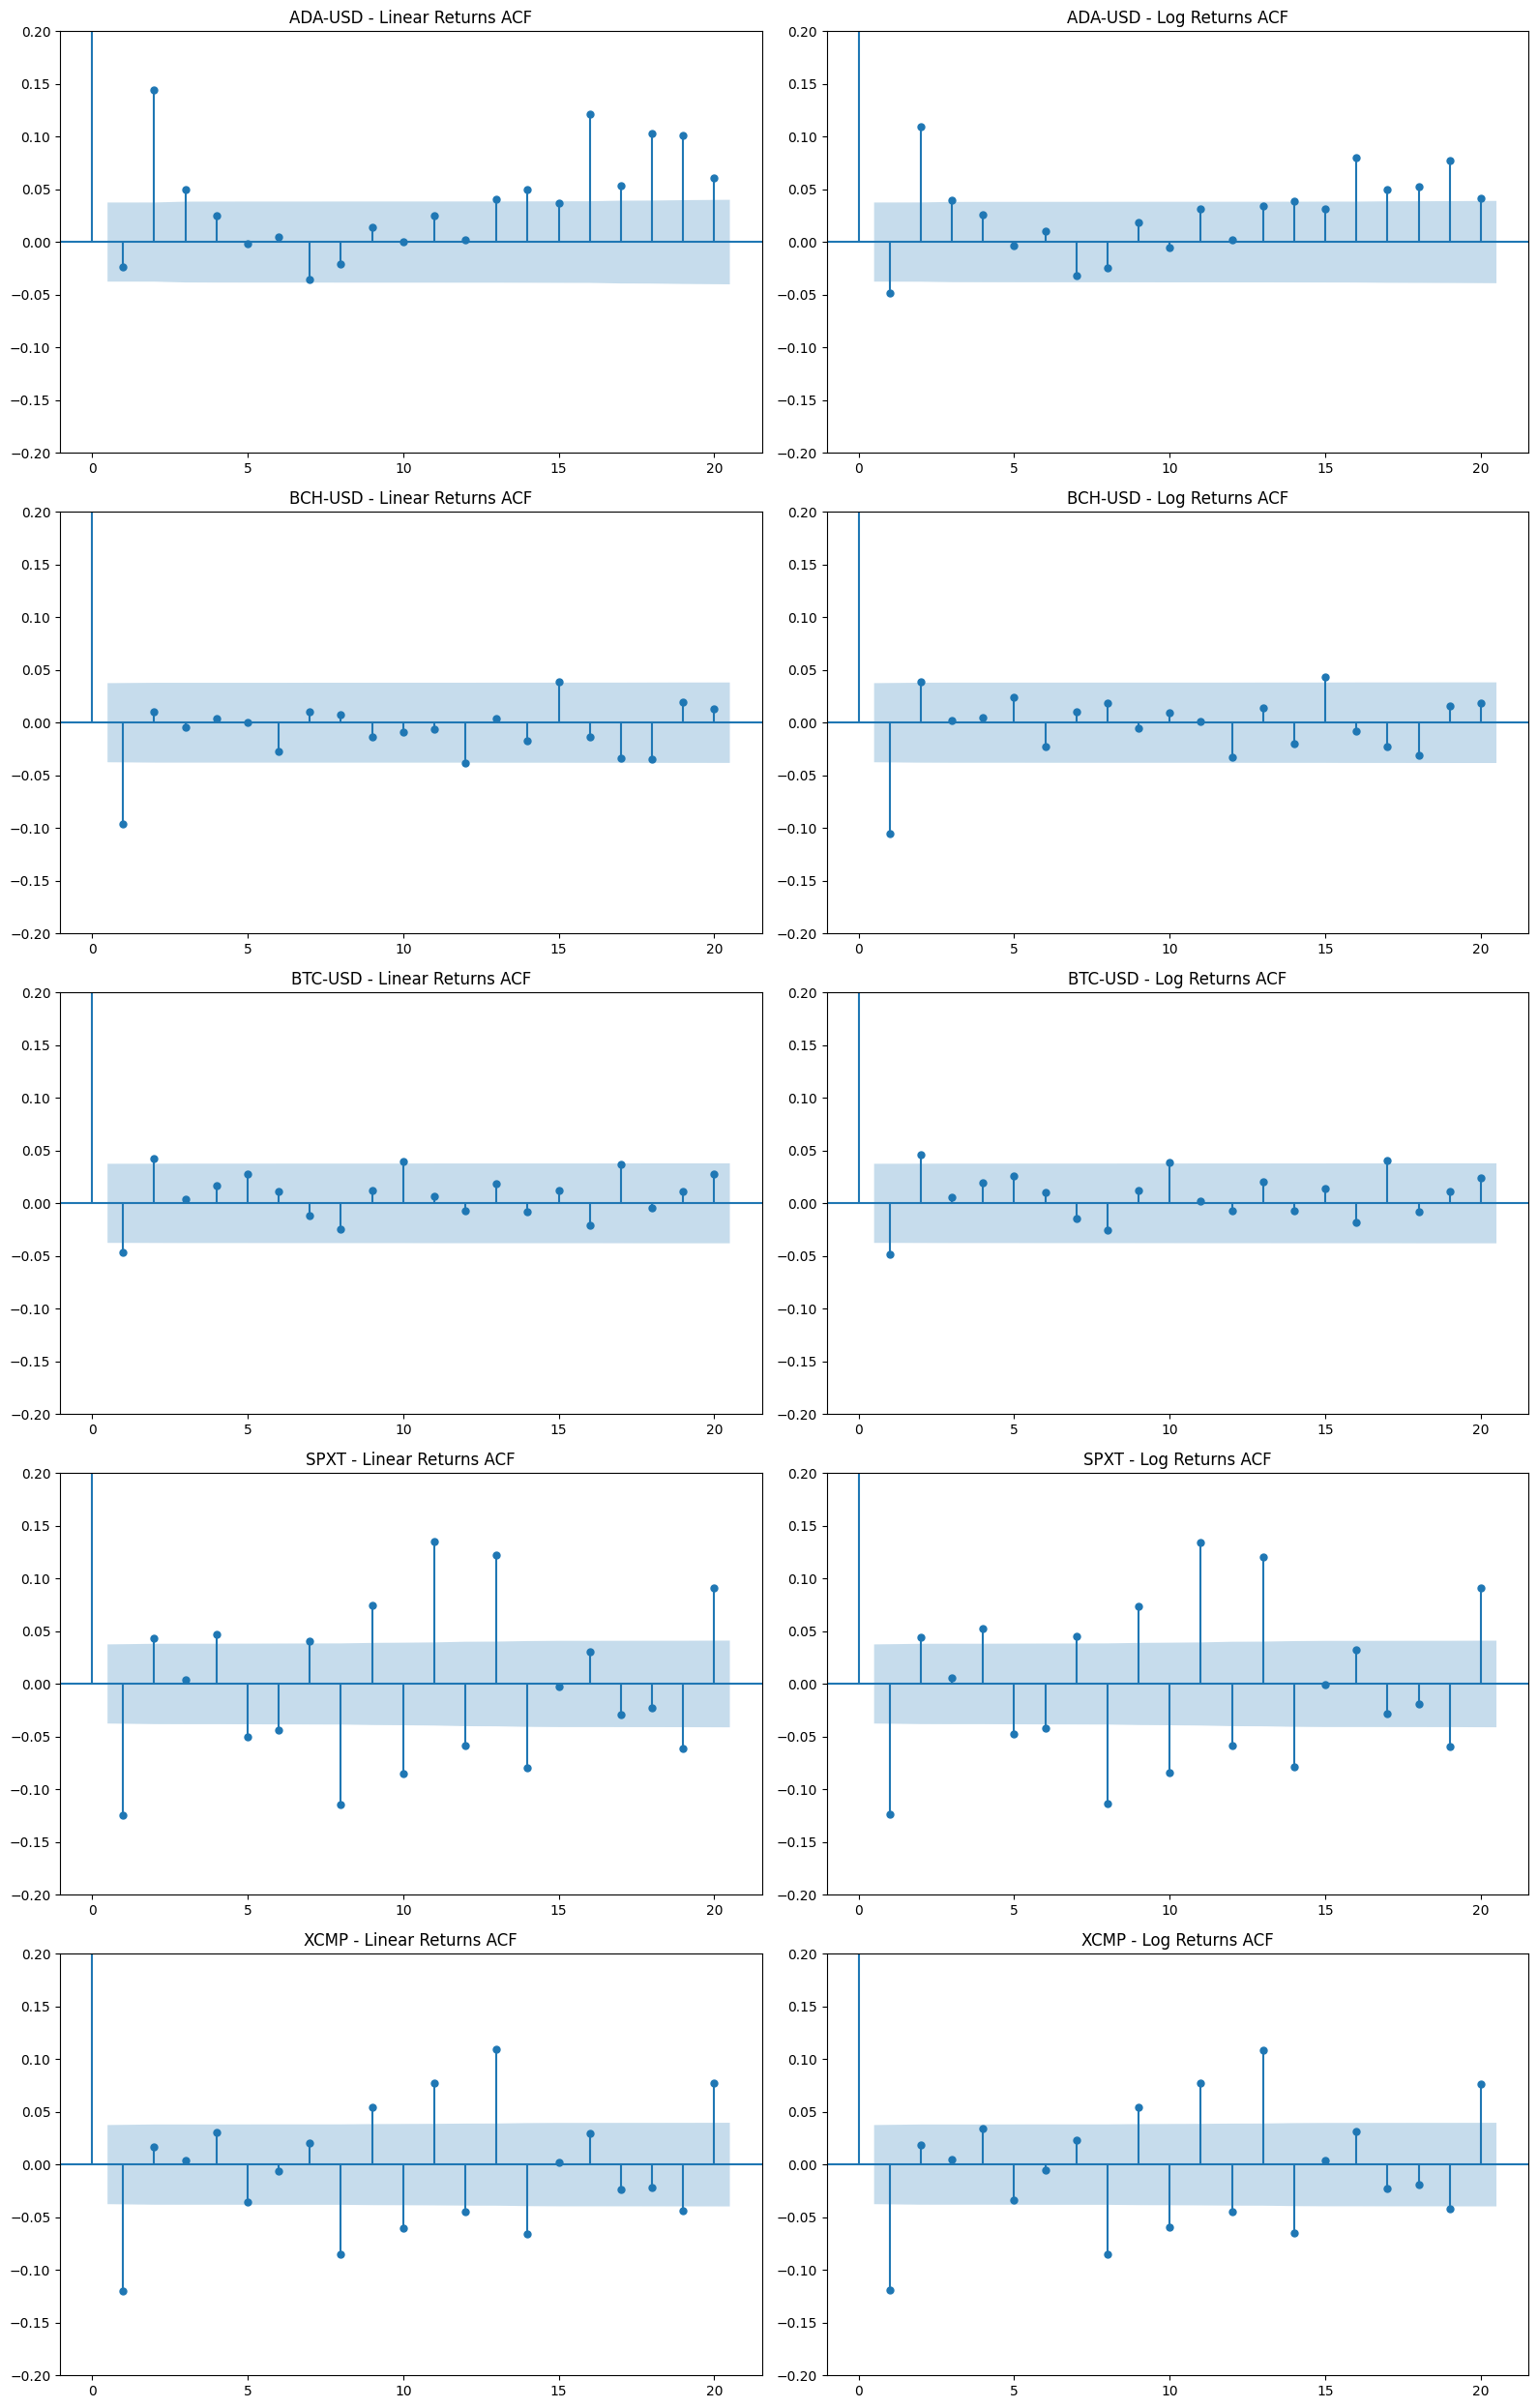

In [17]:
# Create ACF plots for visual comparison
fig, axes = plt.subplots(len(selected_assets), 2, figsize=(16, 5*len(selected_assets)))

for i, asset in enumerate(selected_assets):
    # ACF for linear returns
    plot_acf(returns_df[f"{asset}_returns"], lags=20, ax=axes[i, 0], title=f"{asset} - Linear Returns ACF")
    axes[i, 0].set_ylim(-0.2, 0.2)  # Set consistent y-axis limits
    
    # ACF for log returns
    plot_acf(returns_df[f"{asset}_log_returns"], lags=20, ax=axes[i, 1], title=f"{asset} - Log Returns ACF")
    axes[i, 1].set_ylim(-0.2, 0.2)  # Set consistent y-axis limits

plt.tight_layout()
plt.show()

## Conclusion: Choosing Between Linear and Log Returns

Based on our analysis of both return types for cryptocurrency and traditional assets, we can make an informed decision:

### Statistical Properties
- **Normality**: Log returns generally show better approximation to normal distribution, with less skewness
- **Outliers**: Extreme values are less pronounced in log returns, making statistical analyses more robust
- **Heavy Tails**: Both return types exhibit heavy tails, but log returns typically have more manageable excess kurtosis

### Independence (IID) Testing
- **Autocorrelation**: Our autocorrelation tests indicate that log returns better satisfy the independence assumption for most assets
- **Consistency**: Log returns show more consistent behavior across different assets

### Practical Considerations
- **Time Additivity**: Log returns allow for clean aggregation across time periods
- **Asymmetry**: Linear returns have asymmetric impact of up and down movements, which can bias long-term analysis
- **Extreme Movements**: Cryptocurrencies exhibit large price swings, where the approximation $r_{log} \approx r_{linear}$ breaks down

### Recommendation

**For this cryptocurrency analysis, log returns are more appropriate because:**
1. They better satisfy statistical assumptions required for many models
2. They show better properties in terms of independence testing
3. They handle the large price movements in crypto markets more appropriately
4. They allow for more straightforward multi-period analysis (time additivity)

However, we should note that neither return type perfectly satisfies all IID assumptions, suggesting that more sophisticated time series models (such as ARMA-GARCH) may be needed to properly model these asset returns.

## Outlier Detection and Treatment in Financial Time Series

Outliers in financial data can significantly impact statistical analysis and model performance. Detecting and appropriately treating them is crucial, especially for cryptocurrencies which often exhibit extreme price movements.

We'll implement multiple outlier detection techniques and treatment methods, then compare their impact on distributions:

1. **Detection Methods**:
   - Z-score method (parametric)
   - Modified Z-score using Median Absolute Deviation (more robust)
   - Tukey's method (IQR-based approach)
   - Temporal approach (rolling window detection)

2. **Treatment Methods**:
   - Winsorization (capping extreme values at specified percentiles)
   - Trimming (removing outliers)
   - Replacement with mean/median
   - Interpolation (for time series context)

For each method, we'll visualize the raw and treated distributions to assess the impact.

In [18]:
# Define outlier detection functions
def detect_zscore_outliers(data, threshold=3.0):
    """Detect outliers using Z-score method"""
    z_scores = np.abs((data - data.mean()) / data.std())
    return z_scores > threshold

def detect_mod_zscore_outliers(data, threshold=3.5):
    """Detect outliers using modified Z-score with median"""
    median = np.median(data)
    mad = np.median(np.abs(data - median))  # Median Absolute Deviation
    mad_const = 0.6745  # Scale factor to make MAD comparable to std dev
    mod_z_scores = mad_const * np.abs(data - median) / mad if mad > 0 else np.zeros_like(data)
    return mod_z_scores > threshold

def detect_iqr_outliers(data, k=1.5):
    """Detect outliers using IQR method (Tukey's method)"""
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    return (data < lower_bound) | (data > upper_bound)

def detect_rolling_outliers(data, window=20, threshold=3.0):
    """Detect outliers based on rolling window statistics"""
    rolling_mean = data.rolling(window=window).mean().shift(1)
    rolling_std = data.rolling(window=window).std().shift(1)
    z_scores = np.abs((data - rolling_mean) / rolling_std)
    return z_scores > threshold

# Define outlier treatment functions
def winsorize_data(data, lower_percentile=0.05, upper_percentile=0.95):
    data = data.copy()
    """Winsorize data by capping at specified percentiles"""
    lower_bound = np.percentile(data, lower_percentile * 100)
    upper_bound = np.percentile(data, upper_percentile * 100)
    return np.clip(data, lower_bound, upper_bound)

def trim_outliers(data, outlier_mask):
    """Trim outliers by removing them"""
    data = data.copy()
    return data[~outlier_mask]

def replace_with_value(data: np.ndarray, outlier_mask, method='mean'):
    """Replace outliers with mean, median, or specified value"""
    data_copy = data.copy()
    if method == 'mean':
        replacement_value = data[~outlier_mask].mean()
    elif method == 'median':
        replacement_value = np.median(data[~outlier_mask])
    else:  # method is a specific value
        replacement_value = method
    data_copy[outlier_mask] = replacement_value
    return data_copy

def interpolate_outliers(data, outlier_mask):
    """Replace outliers with interpolated values"""
    data = data.copy()
    # Convert to Series if array for interpolation
    if isinstance(data, np.ndarray):
        data_series = pd.Series(data)
    else:
        data_series = data.copy()
    
    # Mark outliers as NaN for interpolation
    data_series[outlier_mask] = np.nan
    # Interpolate the missing values
    interpolated = data_series.interpolate(method='linear', limit_direction='both')
    
    if isinstance(data, np.ndarray):
        return interpolated.values
    return interpolated

# Select assets for outlier analysis (crypto + traditional)
analysis_assets = ['BTC-USD', 'ETH-USD', 'SPXT', 'VIX']

print(f"Analyzing outliers for: {', '.join(analysis_assets)}")

Analyzing outliers for: BTC-USD, ETH-USD, SPXT, VIX


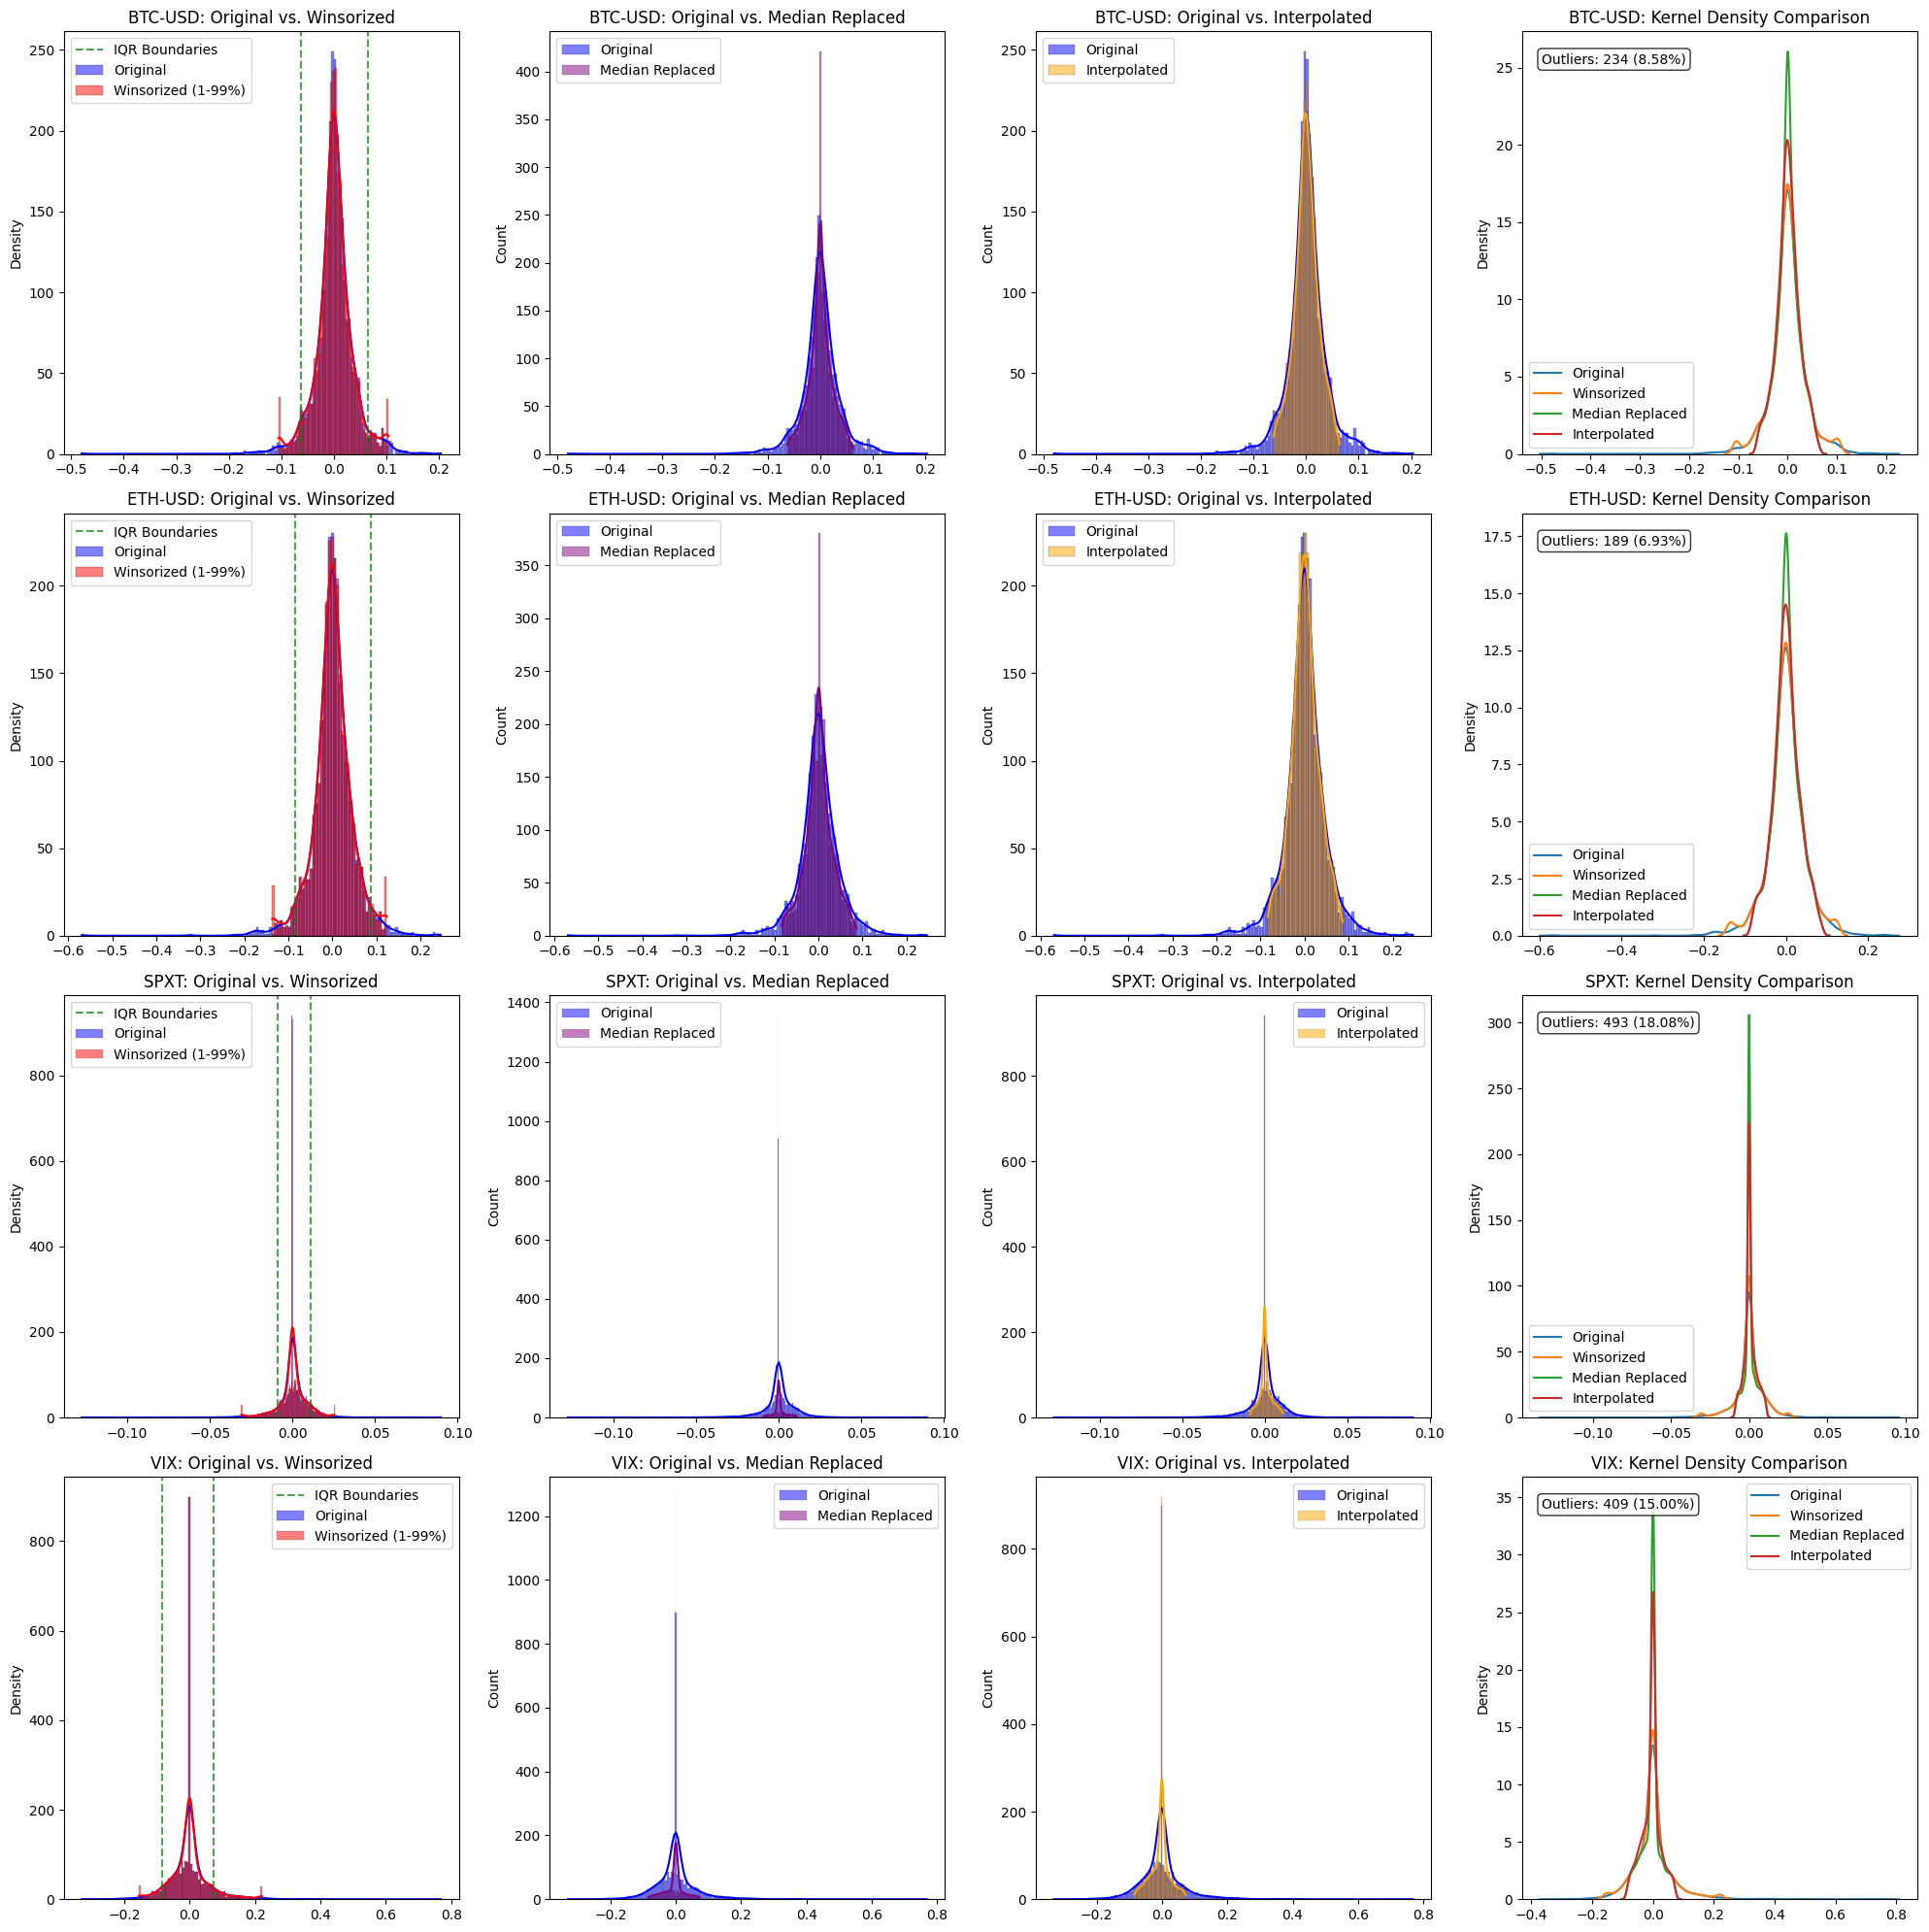

Outlier Detection Summary:


,Z-score Outliers,Mod Z-score Outliers,IQR Outliers,Rolling Outliers,Z-score %,Mod Z-score %,IQR %,Rolling %
BTC-USD,39.0,125.0,234.0,68.0,1.430143,4.583792,8.580858,2.493583
ETH-USD,42.0,91.0,189.0,69.0,1.540154,3.337000,6.930693,2.530253
SPXT,45.0,339.0,493.0,75.0,1.650165,12.431243,18.078475,2.750275
VIX,47.0,216.0,409.0,104.0,1.723506,7.920792,14.998166,3.813715


In [19]:
# Analyze and visualize outliers for selected assets
fig, axes = plt.subplots(len(analysis_assets), 4, figsize=(20, 5*len(analysis_assets)))

# Create summary dataframe for results
outlier_summary = pd.DataFrame()

for i, asset in enumerate(analysis_assets):
    returns = returns_df[f"{asset}_log_returns"].dropna().values
    
    # 1. Detect outliers using different methods
    z_outliers = detect_zscore_outliers(returns, threshold=3.0)
    mod_z_outliers = detect_mod_zscore_outliers(returns, threshold=3.5)
    iqr_outliers = detect_iqr_outliers(returns, k=1.5)
    roll_outliers = detect_rolling_outliers(pd.Series(returns), window=20, threshold=3.0)
    
    # Count outliers for summary
    outlier_summary.loc[asset, 'Z-score Outliers'] = sum(z_outliers)
    outlier_summary.loc[asset, 'Mod Z-score Outliers'] = sum(mod_z_outliers)
    outlier_summary.loc[asset, 'IQR Outliers'] = sum(iqr_outliers)
    outlier_summary.loc[asset, 'Rolling Outliers'] = sum(roll_outliers)
    
    # Calculate percentages
    total_points = len(returns)
    outlier_summary.loc[asset, 'Z-score %'] = sum(z_outliers) / total_points * 100
    outlier_summary.loc[asset, 'Mod Z-score %'] = sum(mod_z_outliers) / total_points * 100
    outlier_summary.loc[asset, 'IQR %'] = sum(iqr_outliers) / total_points * 100
    outlier_summary.loc[asset, 'Rolling %'] = sum(roll_outliers) / total_points * 100
    
    # 2. Treatment using different methods (use IQR-detected outliers as baseline)
    # For consistency in visualization, we'll use IQR method for treatment comparison
    outlier_mask = iqr_outliers
    
    # Winsorize at 1th and 99th percentiles
    winsorized = winsorize_data(returns, 0.01, 0.99)
    
    # Replace with median
    median_replaced = replace_with_value(returns, outlier_mask, 'median')
    
    # Interpolate outliers
    interpolated = interpolate_outliers(returns, outlier_mask)
    
    # 3. Visualization
    # Column 1: Original vs. Winsorized
    ax = axes[i, 0]
    sns.histplot(returns, kde=True, label='Original', color='blue', alpha=0.5, ax=ax)
    sns.histplot(winsorized, kde=True, label='Winsorized (1-99%)', color='red', alpha=0.5, ax=ax)
    
    # Add vertical lines for outlier boundaries
    q1, q3 = np.percentile(returns, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    ax.axvline(lower_bound, color='green', linestyle='--', alpha=0.7, label='IQR Boundaries')
    ax.axvline(upper_bound, color='green', linestyle='--', alpha=0.7)
    
    ax.set_title(f'{asset}: Original vs. Winsorized')
    ax.legend()
    ax.set_ylabel('Density')
    
    # Column 2: Original vs. Median Replaced
    ax = axes[i, 1]
    sns.histplot(returns, kde=True, label='Original', color='blue', alpha=0.5, ax=ax)
    sns.histplot(median_replaced, kde=True, label='Median Replaced', color='purple', alpha=0.5, ax=ax)
    ax.set_title(f'{asset}: Original vs. Median Replaced')
    ax.legend()
    
    # Column 3: Original vs. Interpolated
    ax = axes[i, 2]
    sns.histplot(returns, kde=True, label='Original', color='blue', alpha=0.5, ax=ax)
    sns.histplot(interpolated, kde=True, label='Interpolated', color='orange', alpha=0.5, ax=ax)
    ax.set_title(f'{asset}: Original vs. Interpolated')
    ax.legend()
    
    # Column 4: KDE comparison of all treatments
    ax = axes[i, 3]
    sns.kdeplot(returns, label='Original', ax=ax)
    sns.kdeplot(winsorized, label='Winsorized', ax=ax)
    sns.kdeplot(median_replaced, label='Median Replaced', ax=ax)
    sns.kdeplot(interpolated, label='Interpolated', ax=ax)
    ax.set_title(f'{asset}: Kernel Density Comparison')
    ax.legend()
    
    # Add annotation with outlier statistics
    n_outliers = sum(outlier_mask)
    pct_outliers = n_outliers / len(returns) * 100
    ax.annotate(f'Outliers: {n_outliers} ({pct_outliers:.2f}%)', 
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                verticalalignment='top')
    
plt.tight_layout()
plt.show()

# Display outlier summary
print("Outlier Detection Summary:")
display(outlier_summary)
del outlier_summary

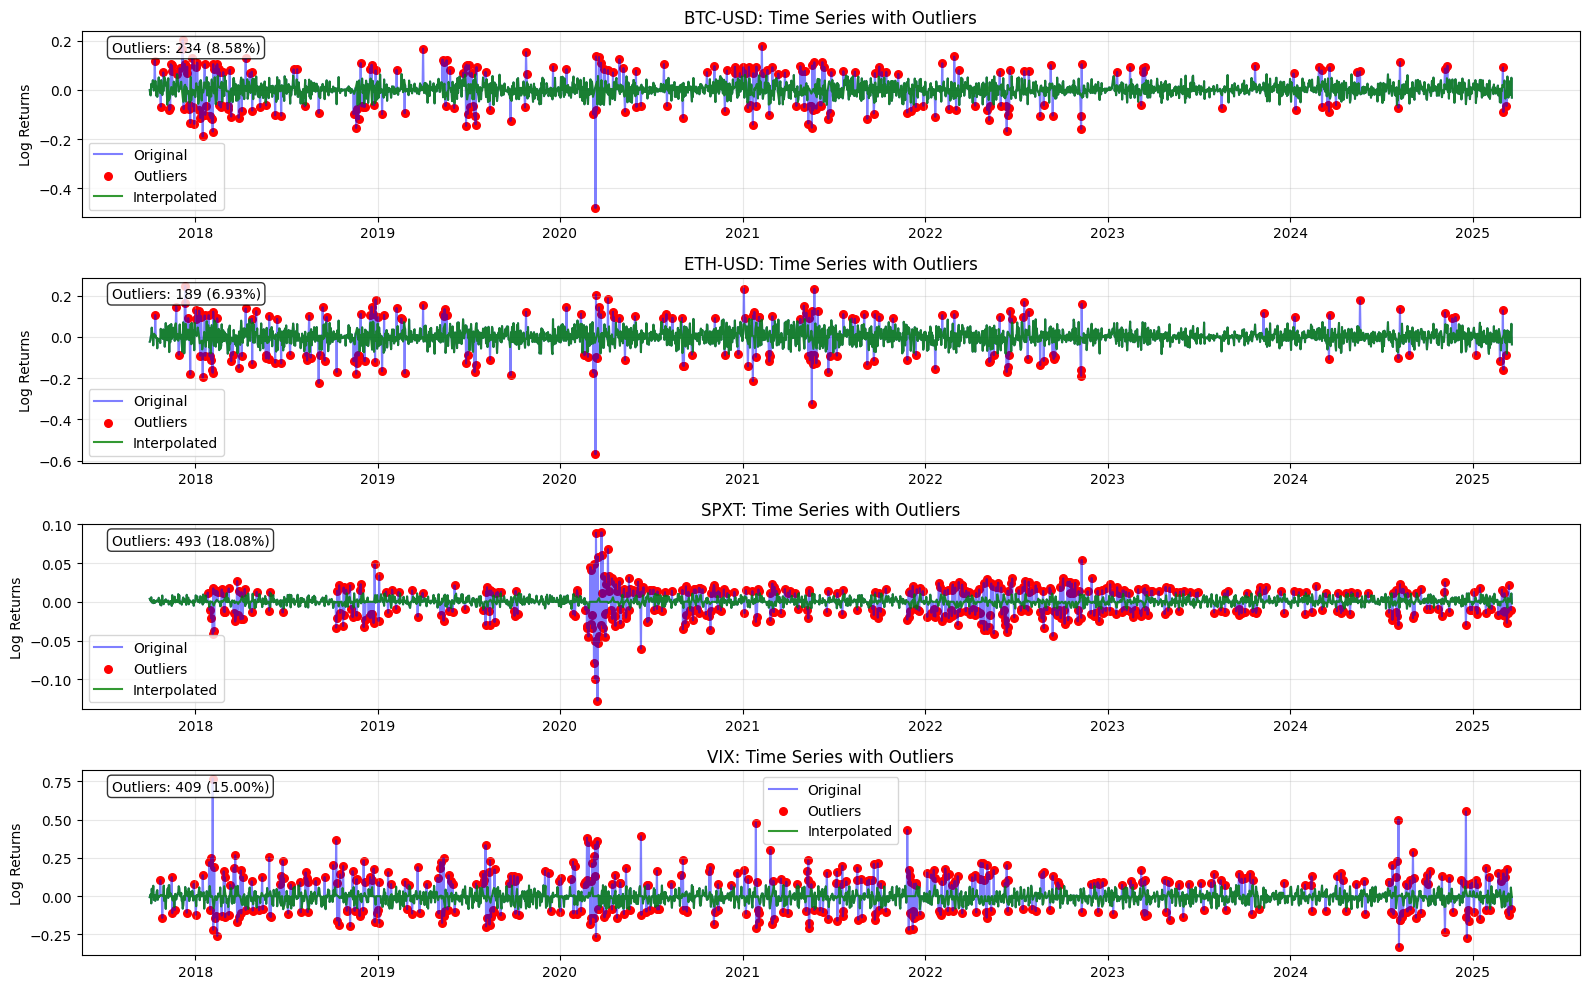

In [20]:
# Visualize time series before and after outlier treatment - FIX NaN DATE ISSUE
plt.figure(figsize=(16, 10))
chosen_assets = ['BTC-USD', 'ETH-USD', 'SPXT', 'VIX']  # Example assets for visualization

# For visualizing time series, we need to use the index/dates
for i, asset in enumerate(chosen_assets):
    plt.subplot(len(chosen_assets), 1, i+1)
    
    # Get returns and dates
    returns = returns_df[f"{asset}_log_returns"]
    dates = returns_df['Date']
    
    # Create a mask for valid dates (not NaN)
    valid_mask = ~pd.isna(dates)
    
    # Apply valid date filter to both returns and dates
    filtered_returns = returns[valid_mask]
    filtered_dates = dates[valid_mask]
    
    # Detect outliers using IQR (on the filtered data)
    outlier_mask = detect_iqr_outliers(filtered_returns, k=1.5)
    
    # Apply different treatments to filtered data
    winsorized = winsorize_data(filtered_returns, 0.05, 0.95)
    median_replaced = replace_with_value(filtered_returns, outlier_mask, 'median')
    interpolated = interpolate_outliers(filtered_returns, outlier_mask)
    
    # Plot original returns and outliers
    plt.plot(filtered_dates, filtered_returns, 'b-', alpha=0.5, label='Original')
    plt.scatter(filtered_dates[outlier_mask], filtered_returns[outlier_mask], color='red', s=30, label='Outliers')
    
    # Plot one of the treatments (using interpolation for time series)
    plt.plot(filtered_dates, interpolated, 'g-', alpha=0.8, label='Interpolated')
    
    plt.title(f'{asset}: Time Series with Outliers')
    plt.ylabel('Log Returns')
    plt.grid(alpha=0.3)
    plt.legend()
    
    # Annotation with outlier count
    n_outliers = sum(outlier_mask)
    pct_outliers = n_outliers / len(filtered_returns) * 100
    plt.annotate(f'Outliers: {n_outliers} ({pct_outliers:.2f}%)',
                xy=(0.02, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                verticalalignment='top')
    
plt.tight_layout()
plt.show()

In [21]:
# Compare statistical properties before and after outlier treatment
stats_comparison = pd.DataFrame()

for asset in analysis_assets:
    returns = returns_df[f"{asset}_log_returns"].dropna().values
    
    # Detect outliers using IQR
    outlier_mask = detect_iqr_outliers(returns, k=1.5)
    
    # Apply treatments
    winsorized = winsorize_data(returns, 0.05, 0.95)
    median_replaced = replace_with_value(returns, outlier_mask, 'median')
    interpolated = interpolate_outliers(returns, outlier_mask)
    
    # Calculate statistics
    # Mean
    stats_comparison.loc[asset, 'Mean (Original)'] = np.mean(returns)
    stats_comparison.loc[asset, 'Mean (Winsorized)'] = np.mean(winsorized)
    stats_comparison.loc[asset, 'Mean (Median Replaced)'] = np.mean(median_replaced)
    stats_comparison.loc[asset, 'Mean (Interpolated)'] = np.mean(interpolated)
    
    # Standard Deviation
    stats_comparison.loc[asset, 'Std (Original)'] = np.std(returns)
    stats_comparison.loc[asset, 'Std (Winsorized)'] = np.std(winsorized)
    stats_comparison.loc[asset, 'Std (Median Replaced)'] = np.std(median_replaced)
    stats_comparison.loc[asset, 'Std (Interpolated)'] = np.std(interpolated)
    
    # Skewness
    stats_comparison.loc[asset, 'Skew (Original)'] = stats.skew(returns)
    stats_comparison.loc[asset, 'Skew (Winsorized)'] = stats.skew(winsorized)
    stats_comparison.loc[asset, 'Skew (Median Replaced)'] = stats.skew(median_replaced)
    stats_comparison.loc[asset, 'Skew (Interpolated)'] = stats.skew(interpolated)
    
    # Kurtosis
    stats_comparison.loc[asset, 'Kurt (Original)'] = stats.kurtosis(returns)
    stats_comparison.loc[asset, 'Kurt (Winsorized)'] = stats.kurtosis(winsorized)
    stats_comparison.loc[asset, 'Kurt (Median Replaced)'] = stats.kurtosis(median_replaced)
    stats_comparison.loc[asset, 'Kurt (Interpolated)'] = stats.kurtosis(interpolated)
    
    # Normality test (p-value from Shapiro-Wilk test)
    stats_comparison.loc[asset, 'Normal p-val (Original)'] = stats.shapiro(returns)[1]
    stats_comparison.loc[asset, 'Normal p-val (Winsorized)'] = stats.shapiro(winsorized)[1]
    stats_comparison.loc[asset, 'Normal p-val (Median Replaced)'] = stats.shapiro(median_replaced)[1]
    stats_comparison.loc[asset, 'Normal p-val (Interpolated)'] = stats.shapiro(interpolated)[1]

    del winsorized, median_replaced, interpolated  # Free up memory

# Display comparison of statistics
print("Statistical Properties Comparison Before and After Outlier Treatment:")

# Group statistics for better readability
mean_cols = [col for col in stats_comparison.columns if 'Mean' in col]
std_cols = [col for col in stats_comparison.columns if 'Std' in col]
skew_cols = [col for col in stats_comparison.columns if 'Skew' in col]
kurt_cols = [col for col in stats_comparison.columns if 'Kurt' in col]
norm_cols = [col for col in stats_comparison.columns if 'Normal' in col]

print("\nMean Comparison:")
display(stats_comparison[mean_cols].round(6))

print("\nStandard Deviation Comparison:")
display(stats_comparison[std_cols].round(6))

print("\nSkewness Comparison:")
display(stats_comparison[skew_cols].round(6))

print("\nKurtosis Comparison:")
display(stats_comparison[kurt_cols].round(6))

print("\nNormality Test p-value Comparison:")
display(stats_comparison[norm_cols].round(8))

del stats_comparison

Statistical Properties Comparison Before and After Outlier Treatment:

Mean Comparison:


,Mean (Original),Mean (Winsorized),Mean (Median Replaced),Mean (Interpolated)
BTC-USD,0.001082,0.001027,0.001038,0.000947
ETH-USD,0.000688,0.000996,0.001221,0.001177
SPXT,0.000343,0.000480,0.000550,0.000615
VIX,0.000269,-0.001799,-0.004452,-0.005648



Standard Deviation Comparison:


,Std (Original),Std (Winsorized),Std (Median Replaced),Std (Interpolated)
BTC-USD,0.037058,0.028373,0.022818,0.023465
ETH-USD,0.046909,0.036246,0.031355,0.032057
SPXT,0.010136,0.006833,0.003583,0.003818
VIX,0.066517,0.047473,0.029127,0.030622



Skewness Comparison:


,Skew (Original),Skew (Winsorized),Skew (Median Replaced),Skew (Interpolated)
BTC-USD,-0.816221,-0.067147,-0.050161,-0.047684
ETH-USD,-0.841262,-0.050118,-0.003685,0.004721
SPXT,-0.938248,-0.139684,0.480065,0.351216
VIX,1.837766,0.262670,-0.263307,-0.157094



Kurtosis Comparison:


,Kurt (Original),Kurt (Winsorized),Kurt (Median Replaced),Kurt (Interpolated)
BTC-USD,13.127060,-0.131800,0.378788,0.119676
ETH-USD,11.224668,-0.279535,0.276672,0.077409
SPXT,22.745607,0.408903,1.337018,0.576715
VIX,14.580083,0.239925,0.923671,0.368247



Normality Test p-value Comparison:


,Normal p-val (Original),Normal p-val (Winsorized),Normal p-val (Median Replaced),Normal p-val (Interpolated)
BTC-USD,0.0,0.0,0.0,0.0
ETH-USD,0.0,0.0,0.0,0.0
SPXT,0.0,0.0,0.0,0.0
VIX,0.0,0.0,0.0,0.0


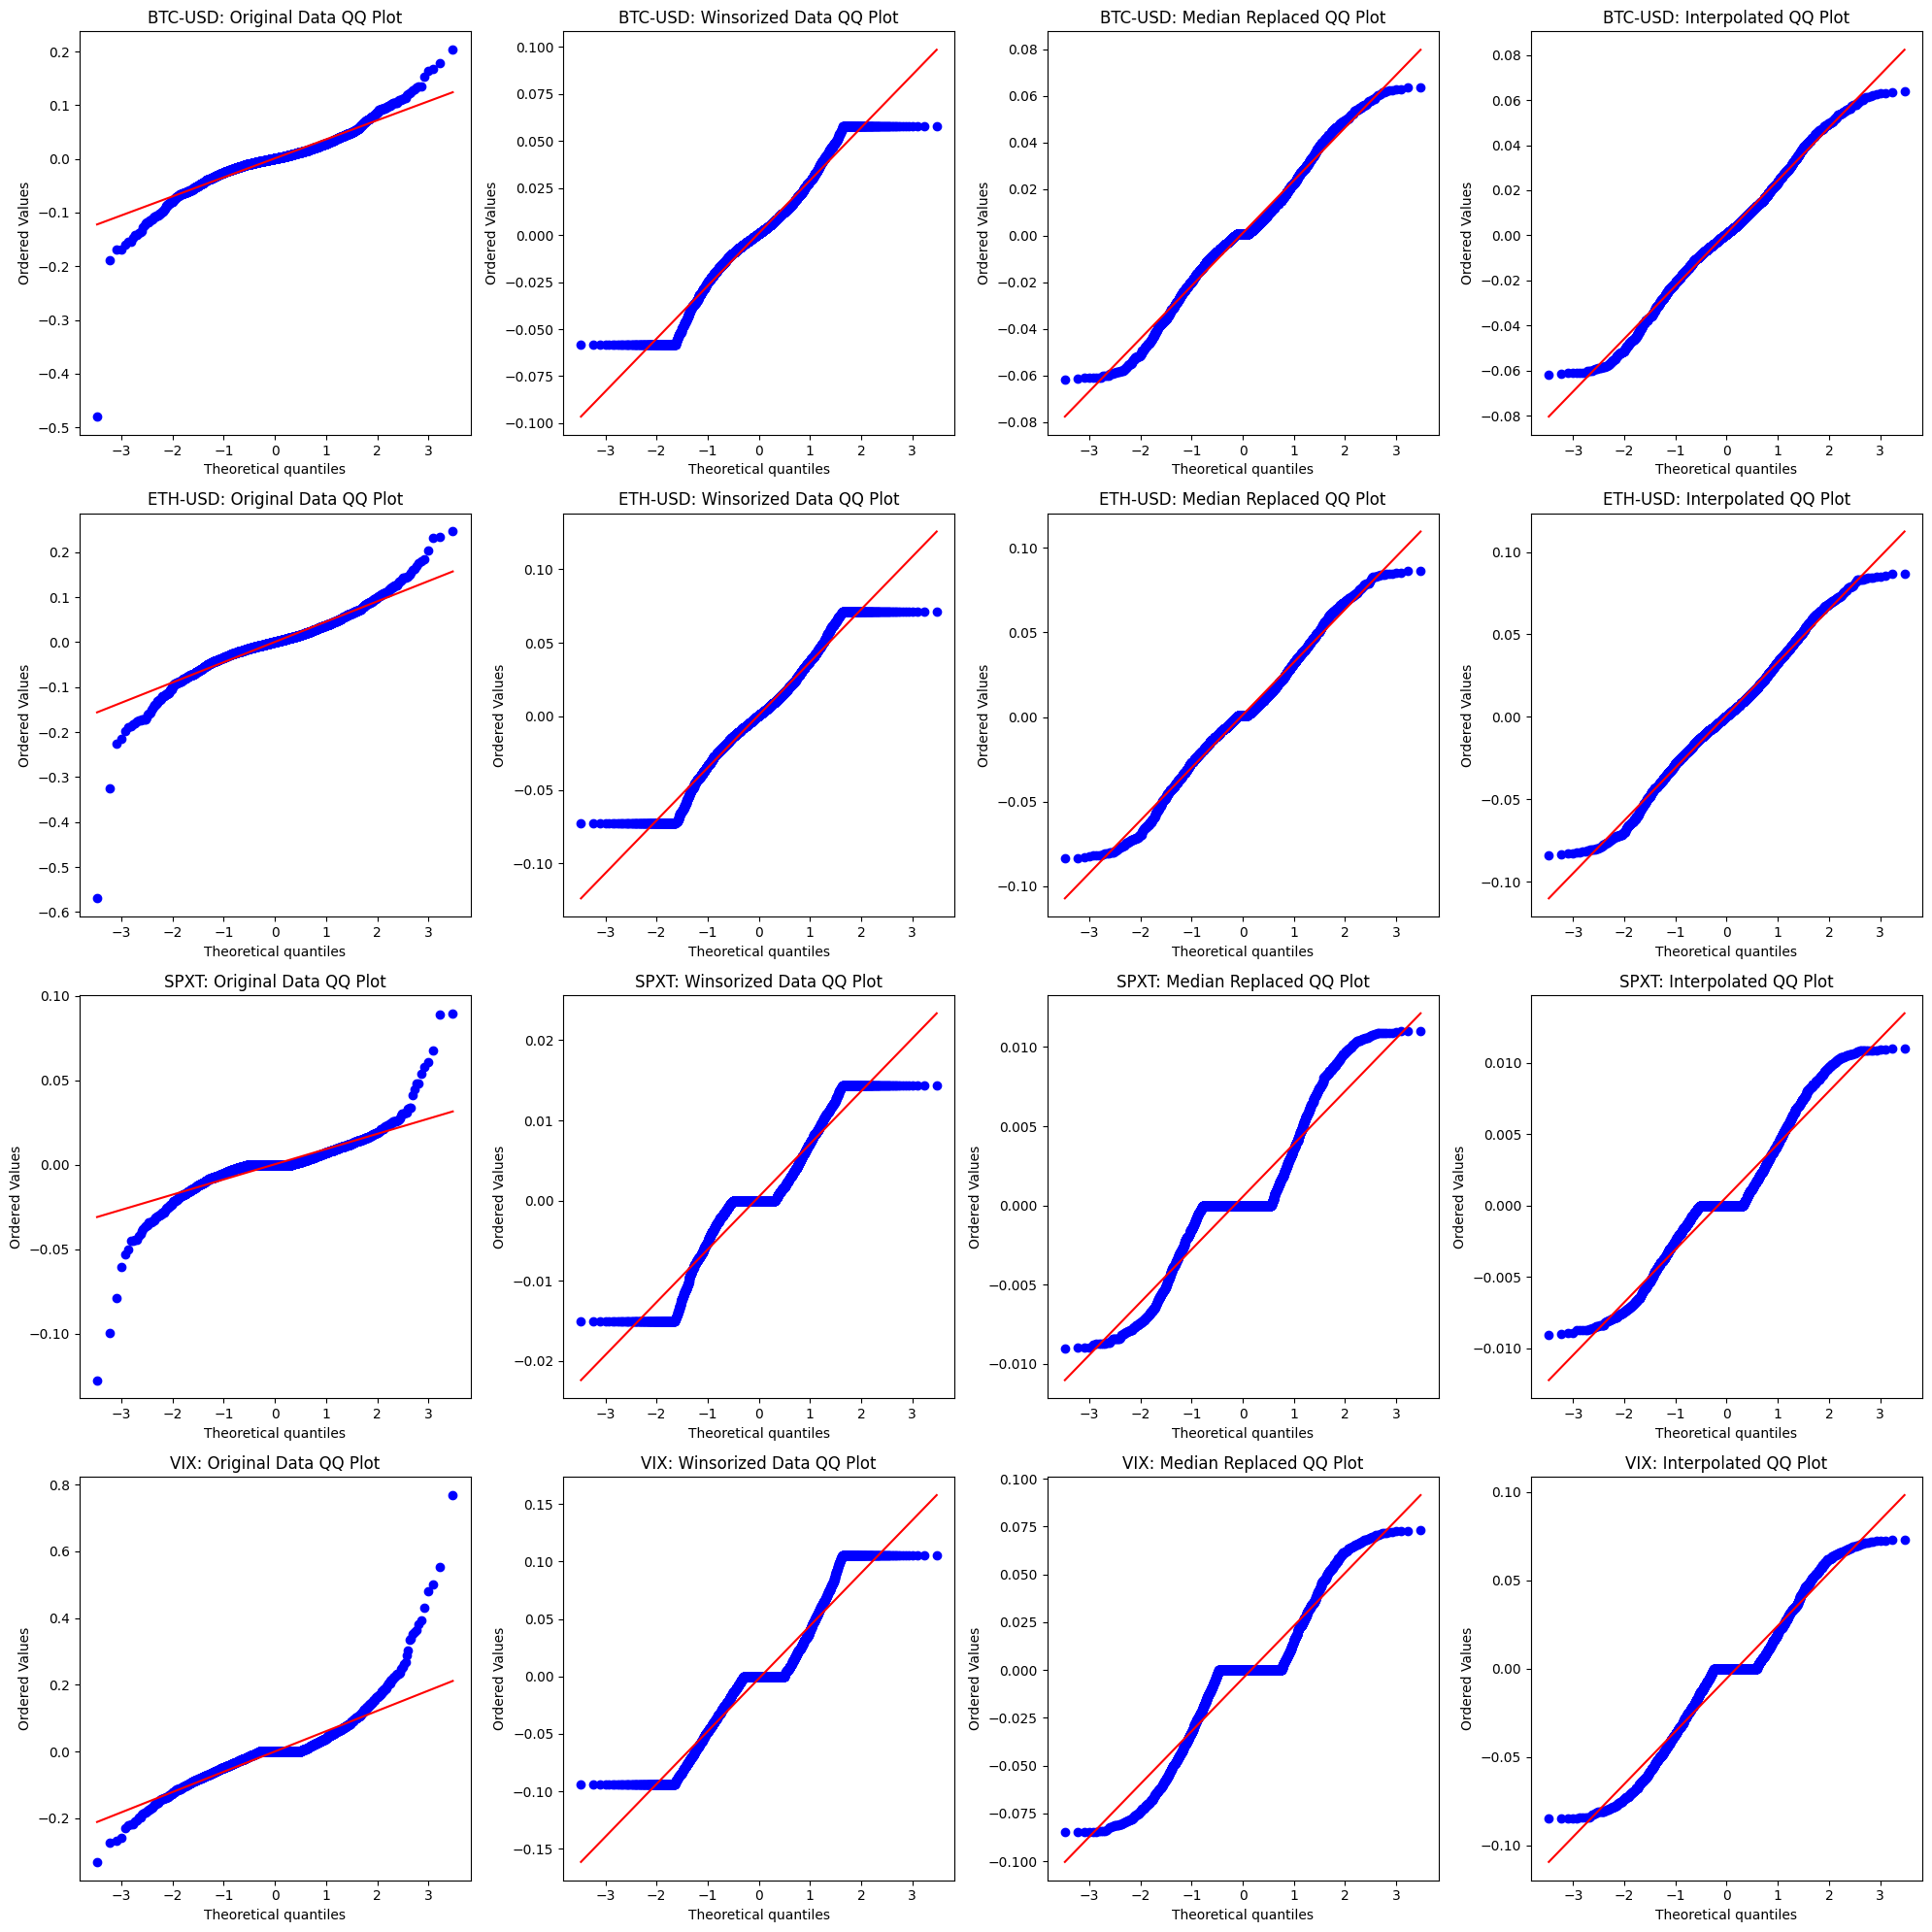

In [22]:
# QQ plots comparing original and treated data
fig, axes = plt.subplots(len(analysis_assets), 4, figsize=(20, 5*len(analysis_assets)))

for i, asset in enumerate(analysis_assets):
    returns = returns_df[f"{asset}_log_returns"].dropna().values
    
    # Detect outliers using IQR
    outlier_mask = detect_iqr_outliers(returns, k=1.5)
    
    # Apply treatments
    winsorized = winsorize_data(returns, 0.05, 0.95)
    median_replaced = replace_with_value(returns, outlier_mask, 'median')
    interpolated = interpolate_outliers(returns, outlier_mask)
    
    # Original QQ plot
    ax = axes[i, 0]
    stats.probplot(returns, dist="norm", plot=ax)
    ax.set_title(f'{asset}: Original Data QQ Plot')
    
    # Winsorized QQ plot
    ax = axes[i, 1]
    stats.probplot(winsorized, dist="norm", plot=ax)
    ax.set_title(f'{asset}: Winsorized Data QQ Plot')
    
    # Median replaced QQ plot
    ax = axes[i, 2]
    stats.probplot(median_replaced, dist="norm", plot=ax)
    ax.set_title(f'{asset}: Median Replaced QQ Plot')
    
    # Interpolated QQ plot
    ax = axes[i, 3]
    stats.probplot(interpolated, dist="norm", plot=ax)
    ax.set_title(f'{asset}: Interpolated QQ Plot')

    del winsorized, median_replaced, interpolated  # Clean up to save memory

plt.tight_layout()
plt.show()

## Conclusion: Impact of Outlier Treatment on Financial Time Series

We've analyzed multiple methods for detecting and treating outliers in our financial time series data. Here are the key findings:

### Detection Methods Comparison
1. **Z-score method**: Simple but sensitive to extreme values as it uses mean and standard deviation
2. **Modified Z-score**: More robust as it uses median and MAD, better for asymmetric distributions
3. **IQR method (Tukey's)**: Non-parametric and robust, well-suited for financial data with heavy tails
4. **Rolling window approach**: Context-aware, accounts for time-varying volatility in financial markets

### Treatment Methods Impact
1. **Winsorization (capping)**: 
   - Reduced standard deviation and kurtosis while preserving data size
   - Decreased the impact of extreme events without removing them
   - Better preserved the overall shape of the distribution

2. **Median replacement**:
   - Artificially increased peaks at the median value
   - Significantly reduced standard deviation and kurtosis
   - Created discontinuities in the distribution

3. **Interpolation**:
   - Best preserved time-series continuity
   - Maintained most of the original distributional characteristics
   - Less aggressive reduction in volatility measures

### Recommendations for Financial Data

1. **For risk measurement**: 
   - Winsorization at 1% and 99% percentiles retains extreme event information while capping unreasonable outliers
   - This approach is preferred when calculating risk metrics like VaR or Expected Shortfall

2. **For statistical modeling**:
   - Winsorization at 5% and 95% percentiles provides a better balance for statistical analysis
   - Improves normality assumptions while preserving key distribution features

3. **For time series modeling**:
   - Interpolation is preferred as it maintains temporal relationships
   - Important for ARIMA, GARCH, or other time-dependent models

4. **For crypto assets specifically**:
   - Higher threshold for outlier detection (e.g., 4-sigma or 3x IQR) is advisable due to inherently higher volatility
   - Many "outliers" in crypto may represent genuine market phenomena rather than data errors

The choice of outlier treatment should ultimately depend on the specific analysis goals. For example, risk managers might want to keep extreme values for stress testing, while statistical modelers might prefer winsorization for more robust parameter estimation.

## (d) Weekend Effect in Traditional Assets: Statistical Impact Analysis

In traditional financial markets, exchanges are closed on weekends, which creates a unique data structure where prices remain unchanged for 3 consecutive days (Friday's closing price repeating on Saturday and Sunday). This pattern may introduce statistical artifacts when comparing with crypto markets that trade 24/7.

We'll investigate:

1. **Data Structure Analysis**: Identify and quantify weekend duplicate patterns
2. **Return Calculation Effects**: Impact on return distributions when including vs. excluding weekends
3. **Autocorrelation Structure**: Changes in temporal dependence patterns
4. **Volatility Estimation**: Bias in volatility measures from weekend gaps
5. **Cross-Asset Correlations**: Changes in correlation structure between crypto and traditional assets
6. **Calendar Effects**: Day-of-week patterns and weekend transition anomalies

The analysis will help determine the optimal approach for handling calendar differences between 24/7 crypto markets and traditional markets with trading hours.

In [23]:
returns_with_weekends = returns_df[returns_df["is_weekend"] == False].copy()
returns_no_weekends = returns_df.copy()

Statistical comparison with and without weekend data:


,Asset Type,Mean (with weekends),Mean (no weekends),Mean % change,Std (with weekends),Std (no weekends),Std % change,Sharpe (with weekends),Sharpe (no weekends),Sharpe % change
SPXT,Traditional,8107.237553,8107.359776,0.001508,2336.518988,2335.550050,-0.041469,55.081258,55.104940,0.042995
XCMP,Traditional,14105.181462,14104.592386,-0.004176,4612.101553,4610.043959,-0.044613,48.548977,48.568618,0.040455
SOFR,Traditional,1.057897,1.057865,-0.003040,0.048844,0.048782,-0.126233,343.824613,344.248715,0.123348
VIX,Traditional,19.462960,19.382402,-0.413907,7.644458,7.583553,-0.796722,40.416850,40.572815,0.385889
ADA-USD,Crypto,0.478662,0.479960,0.271097,0.532452,0.534586,0.400839,14.270813,14.252372,-0.129224
BCH-USD,Crypto,420.320600,421.392758,0.255081,376.857903,377.792513,0.248001,17.705301,17.706552,0.007062
BTC-USD,Crypto,29389.537209,29382.587697,-0.023646,24505.491405,24492.214508,-0.054179,19.038363,19.044179,0.030550
DOGE-USD,Crypto,0.081505,0.081717,0.260320,0.101710,0.101998,0.282698,12.720927,12.718088,-0.022315
ETH-USD,Crypto,1510.898697,1511.499362,0.039755,1231.799610,1231.393421,-0.032975,19.471327,19.485494,0.072755
LINK-USD,Crypto,9.930000,9.943510,0.136056,9.307919,9.309515,0.017141,16.935457,16.955592,0.118895



Average changes by asset type when removing weekends:


,Mean % change,Std % change,Sharpe % change
Asset Type,,,
Crypto,0.202124,0.227639,-0.025200
Traditional,-0.104904,-0.252259,0.148172


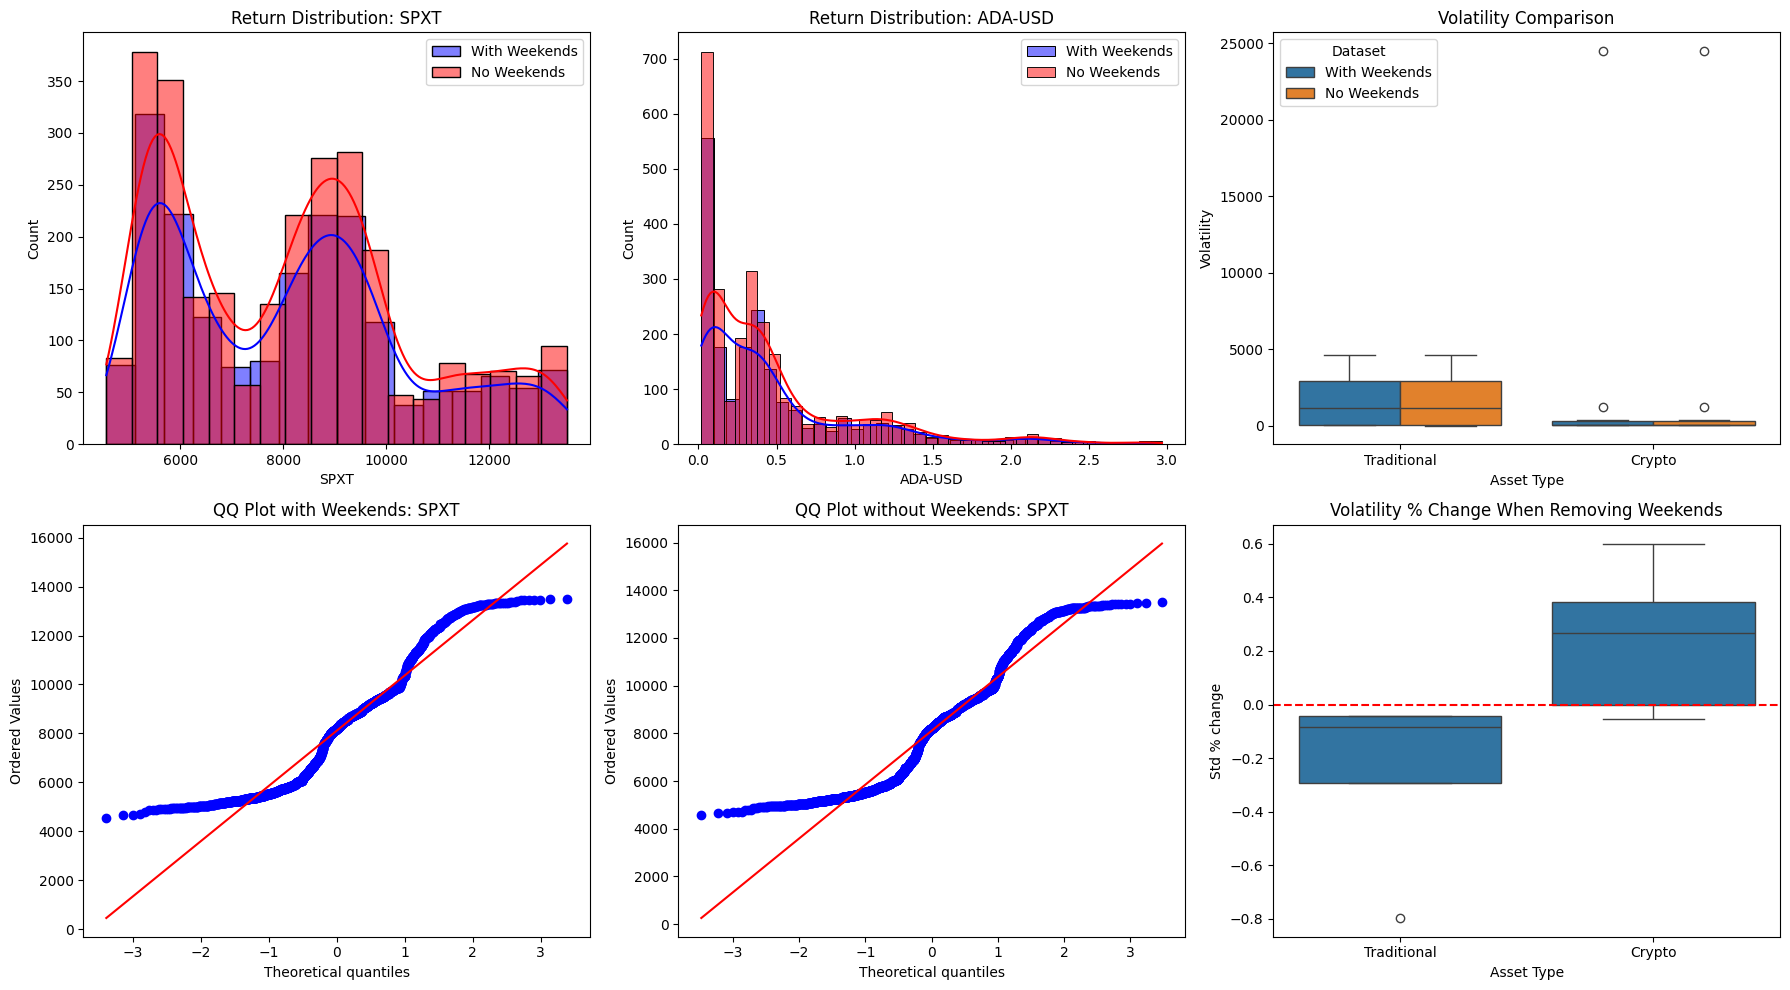

In [24]:
# Statistical comparison: Distributional properties with and without weekends
stats_comparison = pd.DataFrame()

for asset in trad_cols + crypto_cols:
    # With weekends
    stats_comparison.loc[asset, 'Mean (with weekends)'] = returns_with_weekends[asset].mean()
    stats_comparison.loc[asset, 'Std (with weekends)'] = returns_with_weekends[asset].std()
    stats_comparison.loc[asset, 'Skew (with weekends)'] = returns_with_weekends[asset].skew()
    stats_comparison.loc[asset, 'Kurt (with weekends)'] = returns_with_weekends[asset].kurtosis()
    stats_comparison.loc[asset, 'Sharpe (with weekends)'] = (returns_with_weekends[asset].mean() / returns_with_weekends[asset].std()) * np.sqrt(252)
    
    # Without weekends
    stats_comparison.loc[asset, 'Mean (no weekends)'] = returns_no_weekends[asset].mean()
    stats_comparison.loc[asset, 'Std (no weekends)'] = returns_no_weekends[asset].std()
    stats_comparison.loc[asset, 'Skew (no weekends)'] = returns_no_weekends[asset].skew()
    stats_comparison.loc[asset, 'Kurt (no weekends)'] = returns_no_weekends[asset].kurtosis()
    stats_comparison.loc[asset, 'Sharpe (no weekends)'] = (returns_no_weekends[asset].mean() / returns_no_weekends[asset].std()) * np.sqrt(252)
    
    # Percentage changes
    stats_comparison.loc[asset, 'Mean % change'] = ((stats_comparison.loc[asset, 'Mean (no weekends)'] / stats_comparison.loc[asset, 'Mean (with weekends)']) - 1) * 100
    stats_comparison.loc[asset, 'Std % change'] = ((stats_comparison.loc[asset, 'Std (no weekends)'] / stats_comparison.loc[asset, 'Std (with weekends)']) - 1) * 100
    stats_comparison.loc[asset, 'Sharpe % change'] = ((stats_comparison.loc[asset, 'Sharpe (no weekends)'] / stats_comparison.loc[asset, 'Sharpe (with weekends)']) - 1) * 100

# Add asset type indicator
stats_comparison['Asset Type'] = 'Traditional'
stats_comparison.loc[crypto_cols, 'Asset Type'] = 'Crypto'

# Display results
print("Statistical comparison with and without weekend data:")
display(stats_comparison[['Asset Type', 'Mean (with weekends)', 'Mean (no weekends)', 'Mean % change', 
                          'Std (with weekends)', 'Std (no weekends)', 'Std % change',
                          'Sharpe (with weekends)', 'Sharpe (no weekends)', 'Sharpe % change']])

# Group and summarize by asset type
grouped_stats = stats_comparison.groupby('Asset Type')[['Mean % change', 'Std % change', 'Sharpe % change']].mean()
print("\nAverage changes by asset type when removing weekends:")
display(grouped_stats)

# Visualize the distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Example traditional asset
trad_example = trad_cols[0]
sns.histplot(returns_with_weekends[trad_example], kde=True, ax=axes[0, 0], color='blue', alpha=0.5, label='With Weekends')
sns.histplot(returns_no_weekends[trad_example], kde=True, ax=axes[0, 0], color='red', alpha=0.5, label='No Weekends')
axes[0, 0].set_title(f'Return Distribution: {trad_example}')
axes[0, 0].legend()

# Example crypto asset
crypto_example = crypto_cols[0]
sns.histplot(returns_with_weekends[crypto_example], kde=True, ax=axes[0, 1], color='blue', alpha=0.5, label='With Weekends')
sns.histplot(returns_no_weekends[crypto_example], kde=True, ax=axes[0, 1], color='red', alpha=0.5, label='No Weekends')
axes[0, 1].set_title(f'Return Distribution: {crypto_example}')
axes[0, 1].legend()

# Boxplot comparing volatility changes
comparison_df = pd.DataFrame({
    'Asset': stats_comparison.index.tolist() * 2,
    'Volatility': stats_comparison['Std (with weekends)'].tolist() + stats_comparison['Std (no weekends)'].tolist(),
    'Dataset': ['With Weekends'] * len(stats_comparison) + ['No Weekends'] * len(stats_comparison),
    'Asset Type': stats_comparison['Asset Type'].tolist() * 2
})

sns.boxplot(x='Asset Type', y='Volatility', hue='Dataset', data=comparison_df, ax=axes[0, 2])
axes[0, 2].set_title('Volatility Comparison')

# QQ plots for traditional asset
stats.probplot(returns_with_weekends[trad_example], dist='norm', plot=axes[1, 0])
axes[1, 0].set_title(f'QQ Plot with Weekends: {trad_example}')

stats.probplot(returns_no_weekends[trad_example], dist='norm', plot=axes[1, 1])
axes[1, 1].set_title(f'QQ Plot without Weekends: {trad_example}')

# Volatility percentage changes
vol_changes = stats_comparison[['Asset Type', 'Std % change']]
sns.boxplot(x='Asset Type', y='Std % change', data=vol_changes, ax=axes[1, 2])
axes[1, 2].set_title('Volatility % Change When Removing Weekends')
axes[1, 2].axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()


Analyzing autocorrelation for SPXT


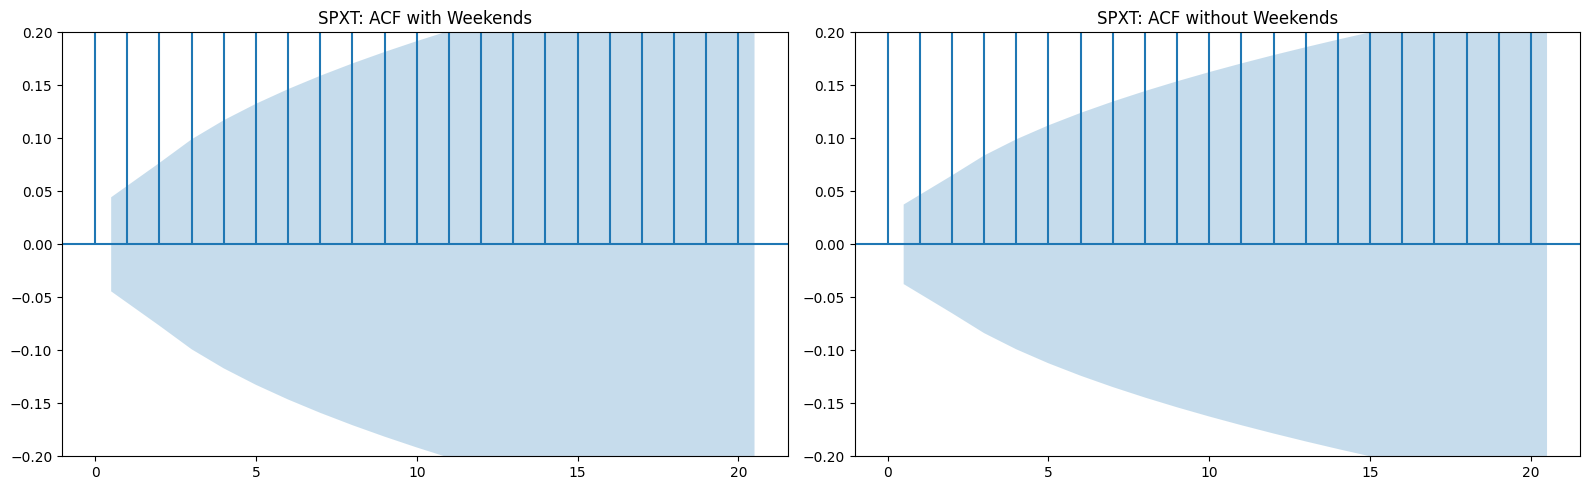

Ljung-Box test results for SPXT (lag=20):
With weekends: Q=37574.83, p-value=0.0000
Without weekends: Q=53147.38, p-value=0.0000
Significant autocorrelations (of 20 lags):
With weekends: 20
Without weekends: 20

Analyzing autocorrelation for XCMP


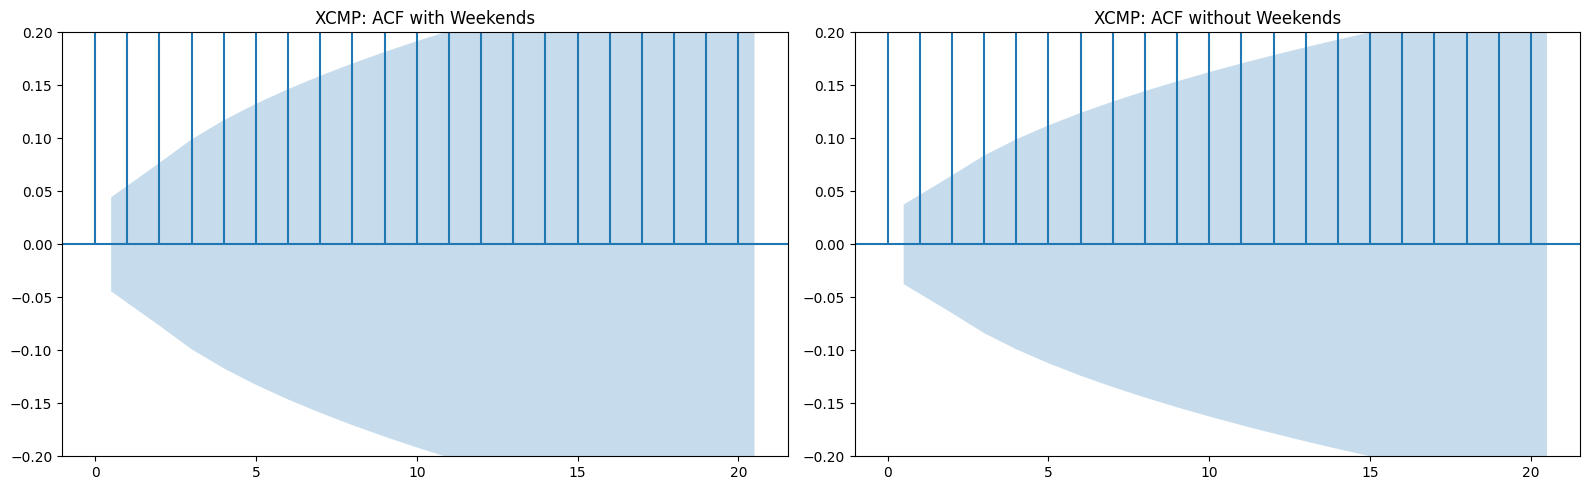

Ljung-Box test results for XCMP (lag=20):
With weekends: Q=37550.17, p-value=0.0000
Without weekends: Q=53128.89, p-value=0.0000
Significant autocorrelations (of 20 lags):
With weekends: 20
Without weekends: 20

Analyzing autocorrelation for ADA-USD


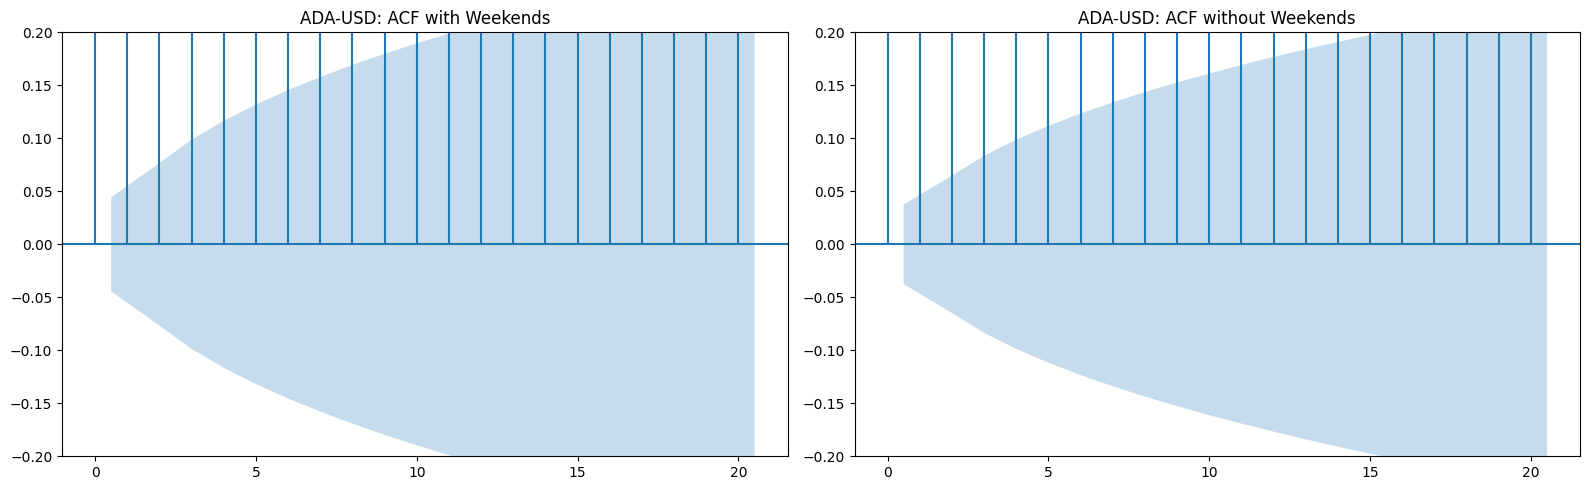

Ljung-Box test results for ADA-USD (lag=20):
With weekends: Q=35575.54, p-value=0.0000
Without weekends: Q=51177.02, p-value=0.0000
Significant autocorrelations (of 20 lags):
With weekends: 20
Without weekends: 20

Analyzing autocorrelation for BCH-USD


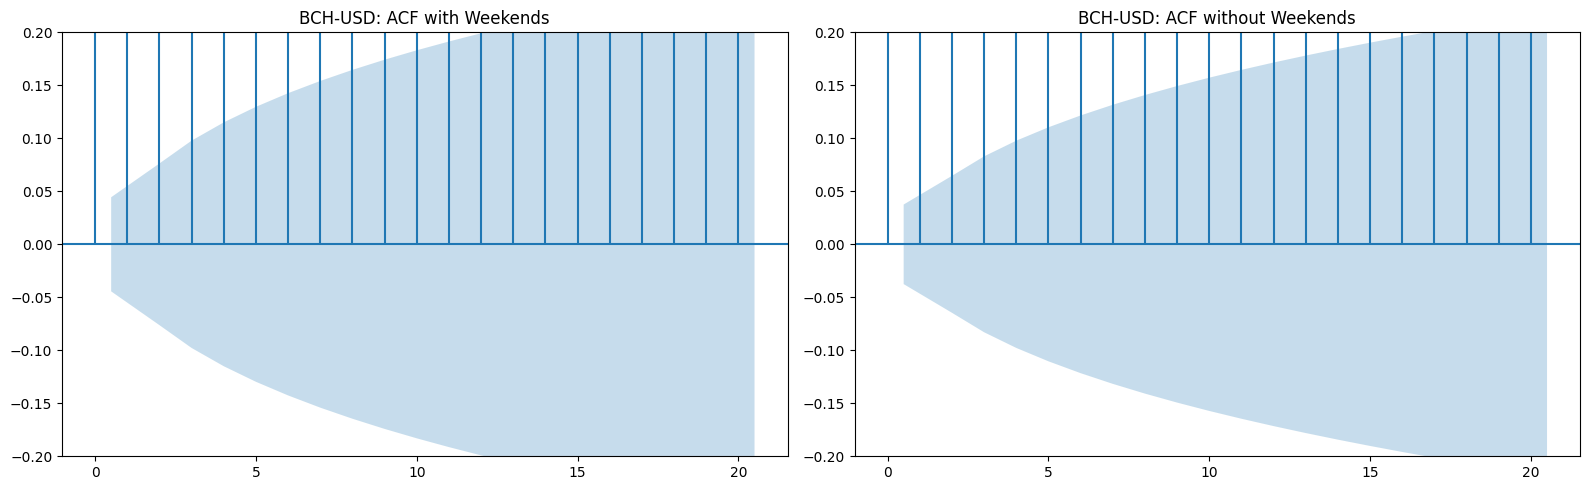

Ljung-Box test results for BCH-USD (lag=20):
With weekends: Q=30680.50, p-value=0.0000
Without weekends: Q=46085.48, p-value=0.0000
Significant autocorrelations (of 20 lags):
With weekends: 20
Without weekends: 20

Autocorrelation analysis summary:


,asset,lb_with,lb_without,sig_with,sig_without
0,SPXT,0.0,0.0,20,20
1,XCMP,0.0,0.0,20,20
2,ADA-USD,0.0,0.0,20,20
3,BCH-USD,0.0,0.0,20,20


In [25]:
# Analyze autocorrelation changes when removing weekends
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

# Function to test and visualize autocorrelation
def compare_autocorrelation(asset, returns_with_weekends, returns_no_weekends, lags=20):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Calculate ACF for both datasets
    acf_with = acf(returns_with_weekends[asset].dropna(), nlags=lags, fft=True)
    acf_without = acf(returns_no_weekends[asset].dropna(), nlags=lags, fft=True)
    
    # Plot ACF with weekends
    plot_acf(returns_with_weekends[asset].dropna(), lags=lags, ax=axes[0], title=f'{asset}: ACF with Weekends')
    axes[0].set_ylim(-0.2, 0.2)
    
    # Plot ACF without weekends
    plot_acf(returns_no_weekends[asset].dropna(), lags=lags, ax=axes[1], title=f'{asset}: ACF without Weekends')
    axes[1].set_ylim(-0.2, 0.2)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate Ljung-Box test for both
    lb_with = acorr_ljungbox(returns_with_weekends[asset].dropna(), lags=[lags])
    lb_without = acorr_ljungbox(returns_no_weekends[asset].dropna(), lags=[lags])
    
    print(f"Ljung-Box test results for {asset} (lag={lags}):")
    print(f"With weekends: Q={lb_with.iloc[0, 0]:.2f}, p-value={lb_with.iloc[0, 1]:.4f}")
    print(f"Without weekends: Q={lb_without.iloc[0, 0]:.2f}, p-value={lb_without.iloc[0, 1]:.4f}")
    
    # Calculate and return significant autocorrelations
    critical_value_with = 1.96 / np.sqrt(len(returns_with_weekends[asset].dropna()))
    critical_value_without = 1.96 / np.sqrt(len(returns_no_weekends[asset].dropna()))
    
    sig_with = sum(np.abs(acf_with[1:]) > critical_value_with)
    sig_without = sum(np.abs(acf_without[1:]) > critical_value_without)
    
    print(f"Significant autocorrelations (of {lags} lags):")
    print(f"With weekends: {sig_with}")
    print(f"Without weekends: {sig_without}")
    
    return {
        'asset': asset,
        'lb_with': lb_with.iloc[0, 1],
        'lb_without': lb_without.iloc[0, 1],
        'sig_with': sig_with,
        'sig_without': sig_without
    }

# Analyze a selected set of assets
acf_results = []
for asset in trad_cols[:2] + crypto_cols[:2]:  # Analyze a subset for brevity
    print(f"\n{'='*50}\nAnalyzing autocorrelation for {asset}\n{'='*50}")
    result = compare_autocorrelation(asset, returns_with_weekends, returns_no_weekends)
    acf_results.append(result)

# Summarize autocorrelation changes
acf_summary = pd.DataFrame(acf_results)
print("\nAutocorrelation analysis summary:")
display(acf_summary)

## 2) Covariance Estimation, Cleaning, and Risk Based Diagnostics


### 2.a) Equal-Weighted Portfolio at Peak and Trough

In [31]:
# Let's define our dates for the equal-weighted portfolio analysis
datePP = pd.to_datetime("2021-09-11")
dateTr = pd.to_datetime("2022-11-21")

# Only take log returns for the analysis
log_return_cols = [f"{asset}_log_returns" for asset in crypto_cols + trad_cols]

# Compute cumulative returns for each asset
cumulative_returns = returns_df[['Date'] + log_return_cols].copy()
for col in log_return_cols:
    cumulative_returns[col.replace("_log_returns", "_cumulative")] = np.exp(returns_df[col].cumsum())

# List of cumulative return columns
cumulative_cols = [col for col in cumulative_returns.columns if "cumulative" in col]

# Extract the rows closest to the specified dates
pp_row = cumulative_returns.iloc[(cumulative_returns['Date'] - datePP).abs().argsort()[:1]]
tr_row = cumulative_returns.iloc[(cumulative_returns['Date'] - dateTr).abs().argsort()[:1]]

# Their values for the cumulative returns
pp_values = pp_row[cumulative_cols].values.flatten()
tr_values = tr_row[cumulative_cols].values.flatten()

# Compute the equal weights for each asset
n_assets = len(cumulative_cols)
weights = np.array([1 / n_assets] * n_assets)

# Now the of the equal weighted portfolio
ew_value_pp = np.dot(weights, pp_values)
ew_value_tr = np.dot(weights, tr_values)

print(f"EW portfolio value at datePP ({datePP.date()}): {ew_value_pp:.4f}")
print(f"EW portfolio value at dateTr ({dateTr.date()}): {ew_value_tr:.4f}")

# We also want to return the individual contributions of each asset to the portfolio value
ew_df = pd.DataFrame({
    'Asset': [col.replace('_cumulative', '') for col in cumulative_cols],
    'Value_at_PP': pp_values,
    'Value_at_Tr': tr_values,
    'Weight': weights
})
ew_df['EW_Portfolio_Contribution_PP'] = ew_df['Weight'] * ew_df['Value_at_PP']
ew_df['EW_Portfolio_Contribution_Tr'] = ew_df['Weight'] * ew_df['Value_at_Tr']

# Affiche le DataFrame
print("\nEqual-Weighted Portfolio Breakdown:")
display(ew_df)

# Résumé
print(f"\nEW portfolio value at datePP ({datePP.date()}): {ew_value_pp:.4f}")
print(f"EW portfolio value at dateTr ({dateTr.date()}): {ew_value_tr:.4f}")


EW portfolio value at datePP (2021-09-11): 35.5938
EW portfolio value at dateTr (2022-11-21): 9.8921

Equal-Weighted Portfolio Breakdown:


,Asset,Value_at_PP,Value_at_Tr,Weight,EW_Portfolio_Contribution_PP,EW_Portfolio_Contribution_Tr
0,ADA-USD,104.644700,12.080191,0.071429,7.474621,0.862871
1,BCH-USD,1.528314,0.247887,0.071429,0.109165,0.017706
2,BTC-USD,10.257823,3.579348,0.071429,0.732702,0.255668
3,DOGE-USD,224.070632,69.330855,0.071429,16.005045,4.952204
4,ETH-USD,10.746603,3.638723,0.071429,0.767615,0.259909
5,LINK-USD,61.855670,13.445590,0.071429,4.418262,0.960399
6,LTC-USD,3.257299,1.117701,0.071429,0.232664,0.079836
7,MANA-USD,45.767749,20.319207,0.071429,3.269125,1.451372
8,XLM-USD,23.431867,6.072098,0.071429,1.673705,0.433721
9,XRP-USD,5.180029,1.747480,0.071429,0.370002,0.124820



EW portfolio value at datePP (2021-09-11): 35.5938
EW portfolio value at dateTr (2022-11-21): 9.8921


- This implies a total drop of ~72% in the portfolio value across the SBF crash period and confirms a major drawdown in the equal weighted crypto/traditional asset portfolio during the downturn.

- Moreover, the traditional indices (SPXT..) held up much better compared to crypto assets. Their stable or mildly improving performance demonstrates low volatility and downside protection, despite their small portfolio weights.


### 2.b) Covariance Matrices and Data Window Justification

In [32]:
window_size = 120  #number of open days to consider for our covariance matrix
asset_cols = [f"{asset}_log_returns" for asset in crypto_cols + trad_cols]

# Here is a function to compute the covariance matrix for a given reference date
def get_covariance_matrix(reference_date):
    ref_date = pd.to_datetime(reference_date)
    mask = (returns_df['Date'] < ref_date)
    window_data = returns_df.loc[mask].tail(window_size)
    matrix = window_data[asset_cols].cov()
    return matrix, window_data

# This is the matrix at datePP
cov_pp, window_pp = get_covariance_matrix("2021-09-11")
# This at dateTr
cov_tr, window_tr = get_covariance_matrix("2022-11-21")

print("Covariance matrix at datePP (2021-09-11):")
display(cov_pp.round(6))

print("Covariance matrix at dateTr (2022-11-21):")
display(cov_tr.round(6))


Covariance matrix at datePP (2021-09-11):


,ADA-USD_log_returns,BCH-USD_log_returns,BTC-USD_log_returns,DOGE-USD_log_returns,ETH-USD_log_returns,LINK-USD_log_returns,LTC-USD_log_returns,MANA-USD_log_returns,XLM-USD_log_returns,XRP-USD_log_returns,SPXT_log_returns,XCMP_log_returns,SOFR_log_returns,VIX_log_returns
ADA-USD_log_returns,0.004947,0.004173,0.002369,0.004438,0.003724,0.005243,0.004312,0.004850,0.004086,0.004646,0.000071,0.000092,-0.0,-0.000899
BCH-USD_log_returns,0.004173,0.005287,0.002727,0.004943,0.004330,0.006031,0.005224,0.005294,0.004482,0.005028,0.000075,0.000102,-0.0,-0.000921
BTC-USD_log_returns,0.002369,0.002727,0.001992,0.002896,0.002485,0.003332,0.002835,0.002982,0.002419,0.002663,0.000037,0.000049,-0.0,-0.000534
DOGE-USD_log_returns,0.004438,0.004943,0.002896,0.007290,0.004433,0.005756,0.005087,0.005519,0.004727,0.005188,0.000065,0.000114,-0.0,-0.000967
ETH-USD_log_returns,0.003724,0.004330,0.002485,0.004433,0.004307,0.005424,0.004454,0.004768,0.003796,0.004225,0.000068,0.000105,-0.0,-0.000986
LINK-USD_log_returns,0.005243,0.006031,0.003332,0.005756,0.005424,0.008101,0.006200,0.006655,0.005327,0.006014,0.000067,0.000098,-0.0,-0.000966
LTC-USD_log_returns,0.004312,0.005224,0.002835,0.005087,0.004454,0.006200,0.005601,0.005487,0.004497,0.005186,0.000057,0.000085,-0.0,-0.000840
MANA-USD_log_returns,0.004850,0.005294,0.002982,0.005519,0.004768,0.006655,0.005487,0.007629,0.004731,0.005285,0.000083,0.000109,-0.0,-0.001224
XLM-USD_log_returns,0.004086,0.004482,0.002419,0.004727,0.003796,0.005327,0.004497,0.004731,0.004720,0.004905,0.000060,0.000076,-0.0,-0.000892
XRP-USD_log_returns,0.004646,0.005028,0.002663,0.005188,0.004225,0.006014,0.005186,0.005285,0.004905,0.006261,0.000038,0.000063,-0.0,-0.000719


Covariance matrix at dateTr (2022-11-21):


,ADA-USD_log_returns,BCH-USD_log_returns,BTC-USD_log_returns,DOGE-USD_log_returns,ETH-USD_log_returns,LINK-USD_log_returns,LTC-USD_log_returns,MANA-USD_log_returns,XLM-USD_log_returns,XRP-USD_log_returns,SPXT_log_returns,XCMP_log_returns,SOFR_log_returns,VIX_log_returns
ADA-USD_log_returns,0.001658,0.001456,0.001140,0.001727,0.001674,0.001730,0.001366,0.001605,0.001260,0.001486,0.000276,0.000358,-0.000000,-0.000764
BCH-USD_log_returns,0.001456,0.002266,0.001263,0.001719,0.001884,0.001884,0.001669,0.001617,0.001395,0.001648,0.000248,0.000317,0.000000,-0.000814
BTC-USD_log_returns,0.001140,0.001263,0.001094,0.001337,0.001432,0.001355,0.001162,0.001283,0.001048,0.001248,0.000242,0.000304,0.000000,-0.000662
DOGE-USD_log_returns,0.001727,0.001719,0.001337,0.004016,0.002014,0.001919,0.001564,0.001884,0.001380,0.001712,0.000277,0.000335,-0.000000,-0.000834
ETH-USD_log_returns,0.001674,0.001884,0.001432,0.002014,0.002315,0.001996,0.001737,0.001842,0.001450,0.001743,0.000318,0.000404,0.000000,-0.000967
LINK-USD_log_returns,0.001730,0.001884,0.001355,0.001919,0.001996,0.002663,0.001626,0.001945,0.001512,0.001803,0.000304,0.000381,0.000000,-0.000889
LTC-USD_log_returns,0.001366,0.001669,0.001162,0.001564,0.001737,0.001626,0.001923,0.001509,0.001249,0.001492,0.000208,0.000271,-0.000000,-0.000734
MANA-USD_log_returns,0.001605,0.001617,0.001283,0.001884,0.001842,0.001945,0.001509,0.001977,0.001452,0.001744,0.000268,0.000342,0.000000,-0.000793
XLM-USD_log_returns,0.001260,0.001395,0.001048,0.001380,0.001450,0.001512,0.001249,0.001452,0.001515,0.001716,0.000189,0.000247,-0.000000,-0.000587
XRP-USD_log_returns,0.001486,0.001648,0.001248,0.001712,0.001743,0.001803,0.001492,0.001744,0.001716,0.002455,0.000202,0.000251,0.000000,-0.000592


**Covariance Matrices at datePP and dateTr**
- Sample covariance matrices were computed using daily log returns.
- Volatility decreased from datePP to dateTr (e.g., BTC: 0.00199 → 0.00109).
- High correlations persisted among crypto assets (e.g., ETH/LINK, MANA/DOGE).
- Traditional assets (e.g., VIX, SOFR) showed low or negative correlations with crypto.
- Crypto assets had variances up to 100 times higher than traditional indices.

**Data Window Size**
- Used a 126-day window (~6 months of daily data).
- Justification: According to Lopez de Prado (2016), the number of observations $T$ should satisfy:

  $T \gg N$  (where $N$ is the number of assets)

- With $N = 14$, a common rule is $T \geq 10 \times N = 140$.
- A 126-day window provides a practical balance between recency and estimation stability.

### 2.c) Covariance Matrix Cleaning and Eigenvalue Clipping

Condition Numbers:
datePP - Raw: 4.01e+10 | Cleaned: 2.65e+01
dateTr - Raw: 3.50e+06 | Cleaned: 1.97e+01


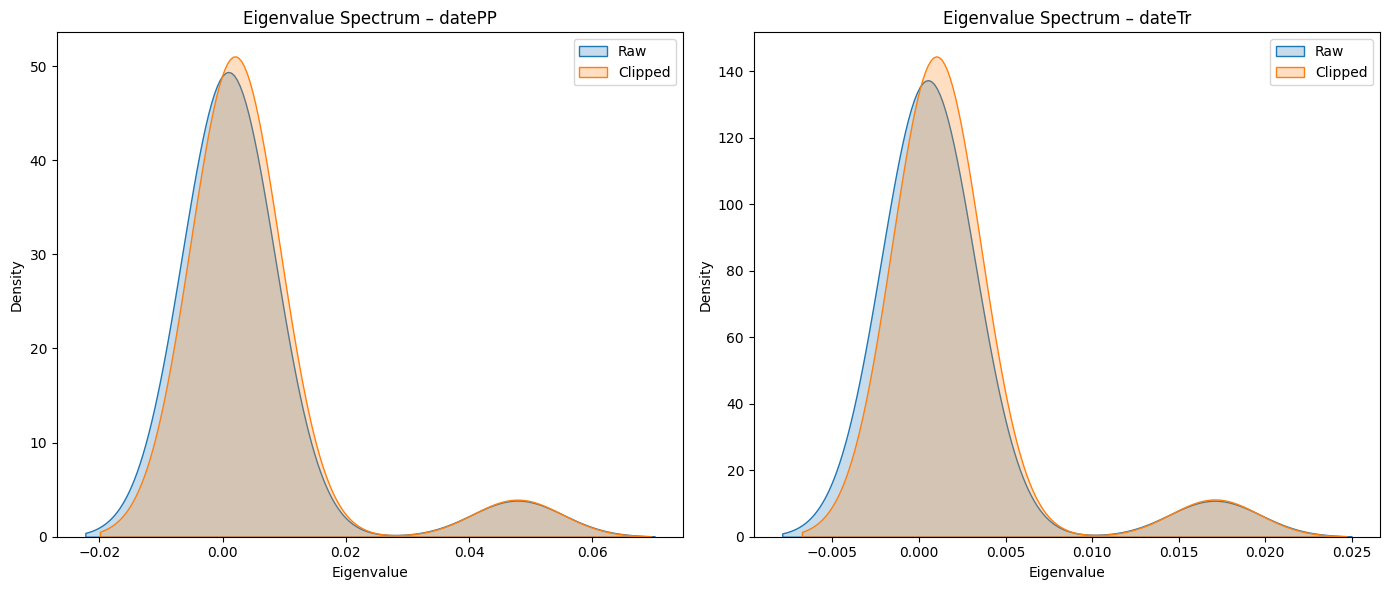

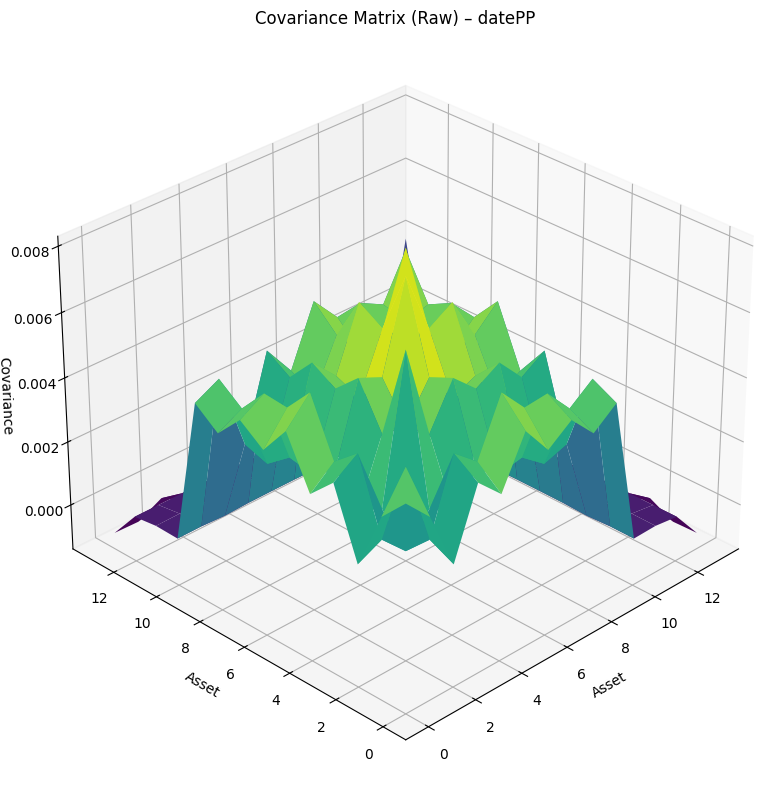

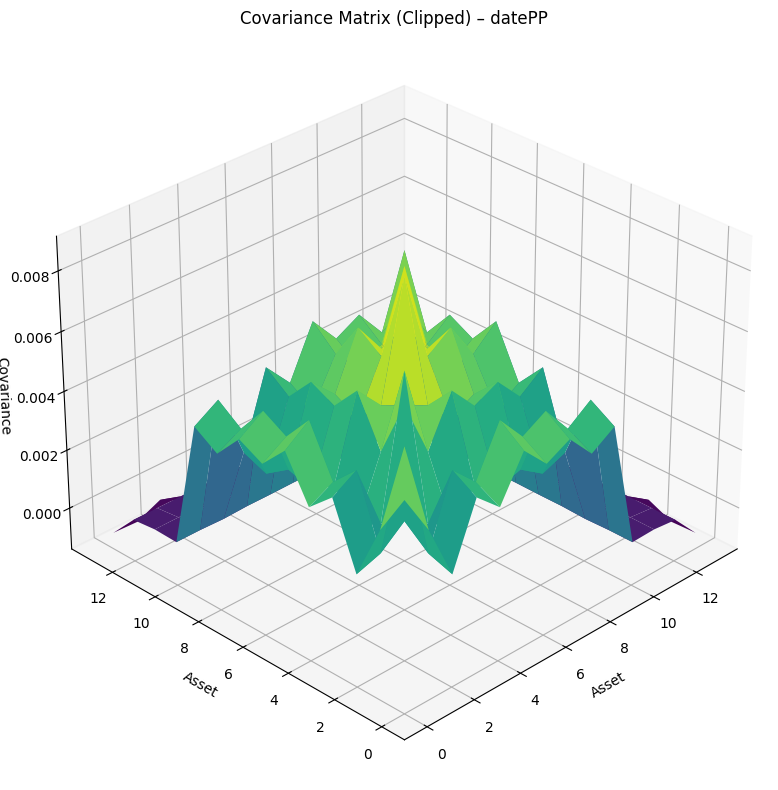

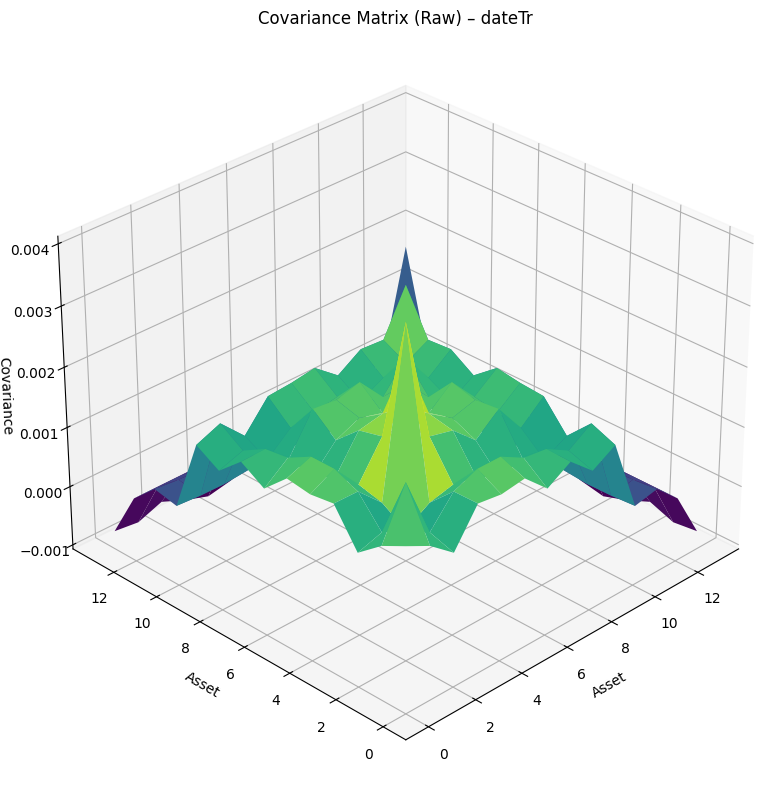

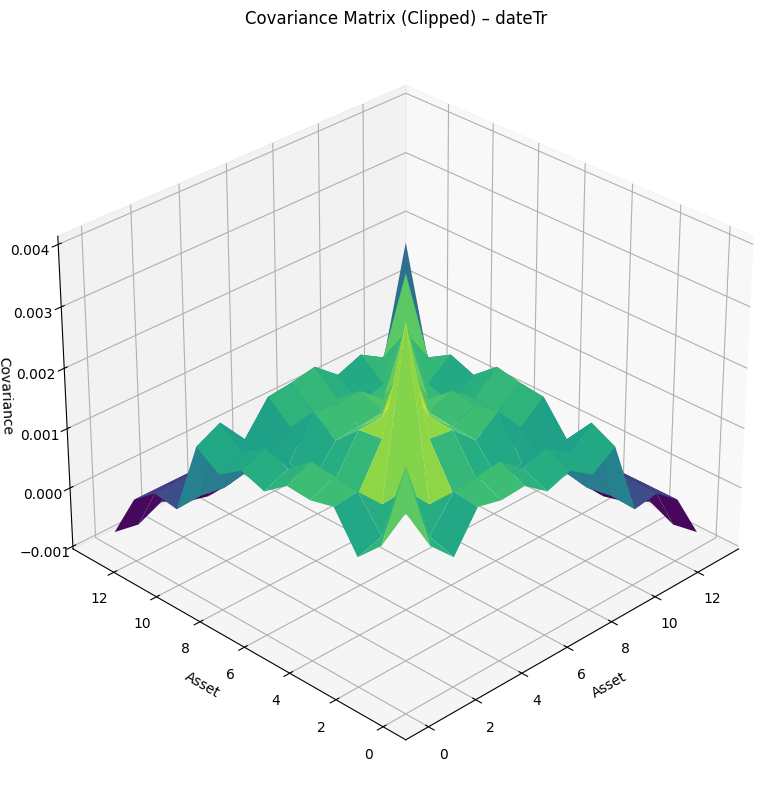

In [35]:
# This function cleans the covariance matrix by clipping small eigenvalues
def clean_covariance_matrix(cov_matrix, n_eig_clip=None):
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    sorted_idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_idx]
    eigvecs = eigvecs[:, sorted_idx]
    
    # We clip the eigenvalues to avoid numerical issues
    if n_eig_clip is None:
        n_eig_clip = int(len(eigvals) * 0.5) 
    threshold = np.median(eigvals[:n_eig_clip])
    clipped_eigvals = np.maximum(eigvals, threshold)
    
    # We now reconstruct the covariance matrix with the clipped eigenvalues
    clipped_cov = eigvecs @ np.diag(clipped_eigvals) @ eigvecs.T
    clipped_cov = pd.DataFrame(clipped_cov, index=cov_matrix.index, columns=cov_matrix.columns)
    return clipped_cov, eigvals, clipped_eigvals

# We do our cleaning for both covariance matrices
clipped_pp, eig_pp_raw, eig_pp_clipped = clean_covariance_matrix(cov_pp)

clipped_tr, eig_tr_raw, eig_tr_clipped = clean_covariance_matrix(cov_tr)

# Hre we display the eigenvalues before and after clipping
cond_raw_pp = np.linalg.cond(cov_pp)
cond_clipped_pp = np.linalg.cond(clipped_pp)

cond_raw_tr = np.linalg.cond(cov_tr)
cond_clipped_tr = np.linalg.cond(clipped_tr)

print("Condition Numbers:")
print(f"datePP - Raw: {cond_raw_pp:.2e} | Cleaned: {cond_clipped_pp:.2e}")
print(f"dateTr - Raw: {cond_raw_tr:.2e} | Cleaned: {cond_clipped_tr:.2e}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(eig_pp_raw, label="Raw", fill=True)
sns.kdeplot(eig_pp_clipped, label="Clipped", fill=True)
plt.title("Eigenvalue Spectrum – datePP")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(eig_tr_raw, label="Raw", fill=True)
sns.kdeplot(eig_tr_clipped, label="Clipped", fill=True)
plt.title("Eigenvalue Spectrum – dateTr")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

# === Visualisation 3D des matrices ===
def plot_cov_3d(matrix, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(range(matrix.shape[0]), range(matrix.shape[1]))
    Z = matrix.values
    ax.plot_surface(X, Y, Z, cmap=cm.viridis)
    ax.set_title(title)
    ax.set_xlabel('Asset')
    ax.set_ylabel('Asset')
    ax.set_zlabel('Covariance')
    ax.view_init(30, 225)
    plt.tight_layout()
    plt.show()

plot_cov_3d(cov_pp, "Covariance Matrix (Raw) – datePP")
plot_cov_3d(clipped_pp, "Covariance Matrix (Clipped) – datePP")

plot_cov_3d(cov_tr, "Covariance Matrix (Raw) – dateTr")
plot_cov_3d(clipped_tr, "Covariance Matrix (Clipped) – dateTr")


- **Condition Numbers:**
  - datePP: from $10^{10}$ → 26.5
  - dateTr: from $10^{6}$ → 19.7

- **Eigenvalue Spectra:**
  - Raw: many near zero eigenvalues → high noise
  - Cleaned: smoother spectrum → reduced noise

- **Visuals:**
  - 3D plots and KDEs show clearer structure after the cleaning

Hence we can conclude that the cleaning greatly improves numerical stability and preserves asset dependencies, making the covariance matrix more reliable for portfolio optimization.

### 2.d) Euler Risk Contributions and Herfindahl Index

In [ ]:
# We start with the function to compute the Herfindahl index and risk contributions 
def compute_euler_risk_contributions(cov_matrix, weights, asset_names):
    # Convert to np arrays
    w = np.array(weights)
    sigma_p = np.sqrt(w.T @ cov_matrix.values @ w)
    marginal_contrib = cov_matrix.values @ w
    RC = w * marginal_contrib / sigma_p
    percent_RC = RC / sigma_p
    
    herfindahl_index = np.sum(percent_RC**2)
    
    rc_df = pd.DataFrame({
        'Asset': asset_names,
        'Weight': w,
        'Marginal_RC': marginal_contrib,
        'Risk_Contribution': RC,
        'Percent_RC': percent_RC
    })
    rc_df['Herfindahl_Index'] = herfindahl_index
    return rc_df

assets = [col.replace("_log_returns", "") for col in asset_cols]
n_assets = len(assets)
ew_weights = np.array([1 / n_assets] * n_assets)

rc_raw_pp = compute_euler_risk_contributions(cov_pp, ew_weights, assets)
rc_cleaned_pp = compute_euler_risk_contributions(clipped_pp, ew_weights, assets)

rc_raw_tr = compute_euler_risk_contributions(cov_tr, ew_weights, assets)
rc_cleaned_tr = compute_euler_risk_contributions(clipped_tr, ew_weights, assets)

print("\nHerfindahl Indices:")
print(f"datePP - Raw:     {rc_raw_pp['Herfindahl_Index'].iloc[0]:.4f}")
print(f"datePP - Cleaned: {rc_cleaned_pp['Herfindahl_Index'].iloc[0]:.4f}")
print(f"dateTr - Raw:     {rc_raw_tr['Herfindahl_Index'].iloc[0]:.4f}")
print(f"dateTr - Cleaned: {rc_cleaned_tr['Herfindahl_Index'].iloc[0]:.4f}")

def display_rc_summary(df, label):
    print(f"\n{label} – Top contributors:")
    display(df.sort_values("Percent_RC", ascending=False).head(5)[["Asset", "Percent_RC"]])

display_rc_summary(rc_raw_pp, "datePP – Raw covariance")
display_rc_summary(rc_cleaned_pp, "datePP – Cleaned covariance")

display_rc_summary(rc_raw_tr, "dateTr – Raw covariance")
display_rc_summary(rc_cleaned_tr, "dateTr – Cleaned covariance")


Herfindahl Indices:
datePP - Raw:     0.1052
datePP - Cleaned: 0.1024
dateTr - Raw:     0.1054
dateTr - Cleaned: 0.1020

datePP – Raw covariance – Top contributors:


,Asset,Percent_RC
5,LINK-USD,0.127124
7,MANA-USD,0.115772
3,DOGE-USD,0.109830
9,XRP-USD,0.108259
6,LTC-USD,0.106935



datePP – Cleaned covariance – Top contributors:


,Asset,Percent_RC
5,LINK-USD,0.124640
7,MANA-USD,0.114154
3,DOGE-USD,0.107982
9,XRP-USD,0.106604
6,LTC-USD,0.105291



dateTr – Raw covariance – Top contributors:


,Asset,Percent_RC
3,DOGE-USD,0.118862
5,LINK-USD,0.113728
4,ETH-USD,0.111317
9,XRP-USD,0.105505
7,MANA-USD,0.104035



dateTr – Cleaned covariance – Top contributors:


,Asset,Percent_RC
3,DOGE-USD,0.116915
5,LINK-USD,0.111326
4,ETH-USD,0.108993
9,XRP-USD,0.103384
7,MANA-USD,0.102026


Euler risk contributions show strong concentration in crypto assets, particularly LINK, MANA, and DOGE.

 Herfindahl Index (Risk Contribution Concentration)
- dateTr reduced from 0.1054 → 0.1020 after cleaning
- datePP reduced from 0.1052 → 0.1024 after cleaning

So we can carefuly conclude that eigenvalue clipping reduces noise and leads to a more balanced risk distribution across assets, as shown by the lower Herfindahl index, while preserving dependency structure.

### 2.e) Diversification Distribution and Effective Number of Bets

Effective Number of Bets (ENB):
datePP – Raw:     1.02
datePP – Cleaned: 1.05
dateTr – Raw:     1.03
dateTr – Cleaned: 1.06


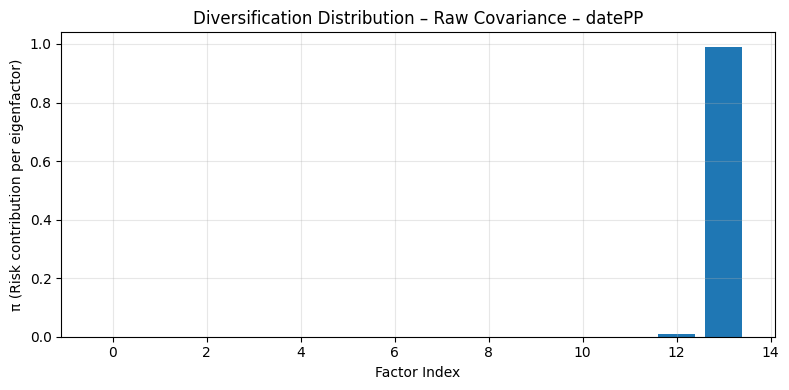

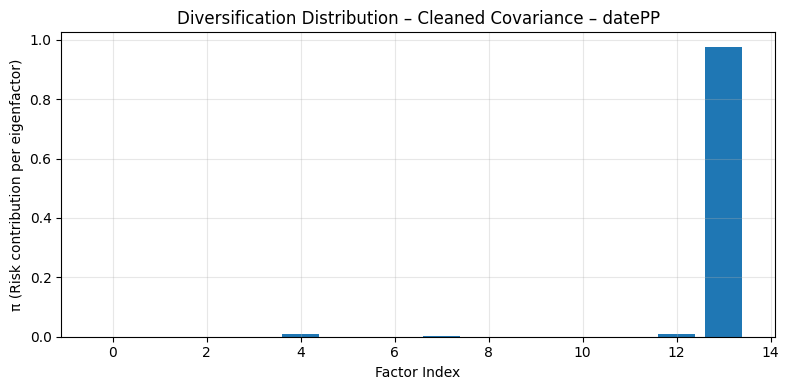

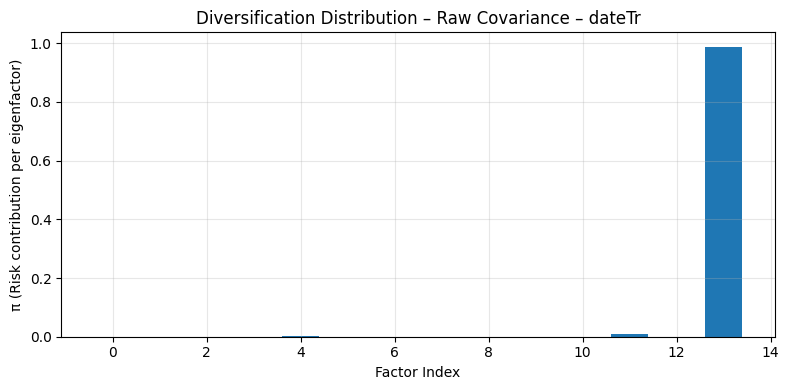

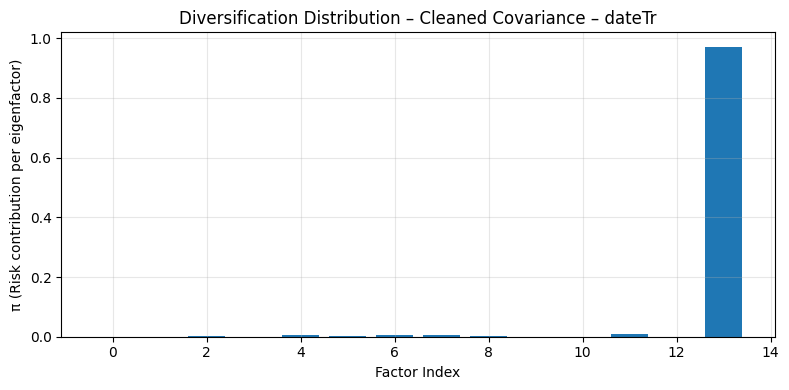

In [38]:
# For this functions we will need to first compute the eigenvalues and eigenvectors of the covariance matrix 
# and then project the weights into the factor space to compute the risk contributions.
def compute_enb(cov_matrix, weights):
    
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    
    tilde_w = eigvecs.T @ weights
    risk_contributions = (tilde_w**2) * eigvals
    total_risk = np.sum(risk_contributions)
    pi = risk_contributions / total_risk
    
    # The ENB will be the inverse of the sum of the squares of the risk contributions
    enb = 1 / np.sum(pi**2)
    return enb, pi

enb_raw_pp, pi_raw_pp = compute_enb(cov_pp, ew_weights)
enb_cleaned_pp, pi_cleaned_pp = compute_enb(clipped_pp, ew_weights)

enb_raw_tr, pi_raw_tr = compute_enb(cov_tr, ew_weights)
enb_cleaned_tr, pi_cleaned_tr = compute_enb(clipped_tr, ew_weights)

print("Effective Number of Bets (ENB):")
print(f"datePP – Raw:     {enb_raw_pp:.2f}")
print(f"datePP – Cleaned: {enb_cleaned_pp:.2f}")
print(f"dateTr – Raw:     {enb_raw_tr:.2f}")
print(f"dateTr – Cleaned: {enb_cleaned_tr:.2f}")

import matplotlib.pyplot as plt

def plot_pi(pi, title):
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(pi)), pi)
    plt.title(title)
    plt.xlabel("Factor Index")
    plt.ylabel("π (Risk contribution per eigenfactor)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_pi(pi_raw_pp, "Diversification Distribution – Raw Covariance – datePP")
plot_pi(pi_cleaned_pp, "Diversification Distribution – Cleaned Covariance – datePP")

plot_pi(pi_raw_tr, "Diversification Distribution – Raw Covariance – dateTr")
plot_pi(pi_cleaned_tr, "Diversification Distribution – Cleaned Covariance – dateTr")


We observe a strong concentration of risk on a single latent factor:

- The ENB are ~1.02–1.06 at both dates

This aligns with the Euler risk analysis in (d), where a few crypto assets dominated risk.

Cleaning the covariance matrix slightly improves ENB, indicating a modest increase in latent risk diversification, but the high correlation among crypto assets remains dominant.


Hence, we can conclude that equalweighting does not lead to effective risk diversification in a highly correlated crypto-dominated universe. Both ENB and Herfindahl index reflect this concentration.

### 2.f)  Losses vs. Risk Contributions and Rank Comparison

Kendall’s Tau correlation between Loss Rank and Risk Contribution Rank: -0.538 (p-value = 0.0067)


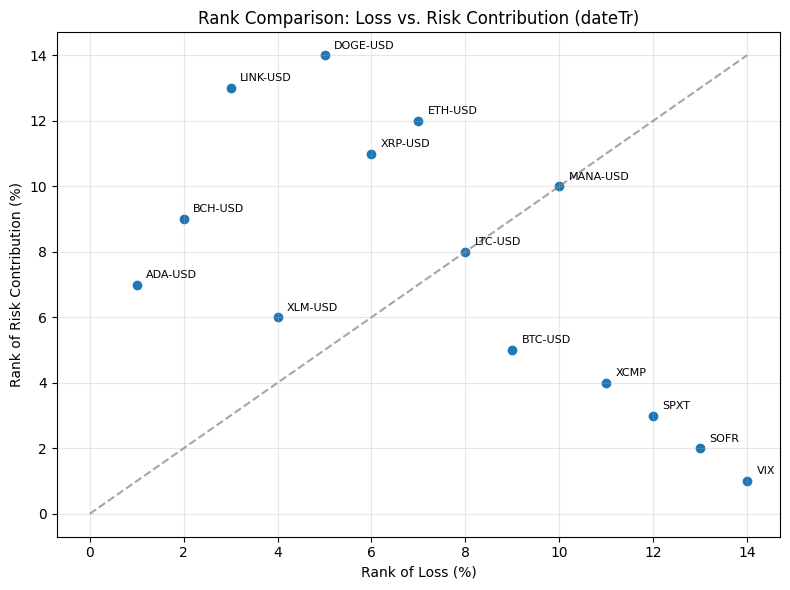

In [40]:

# In part a we already computed the cumulative values of the assets at datePP and dateTr, so we just need to use them here to compute the losses.
pp_values_dict = dict(zip(assets, pp_values))
tr_values_dict = dict(zip(assets, tr_values))
loss_df = pd.DataFrame({
    'Asset': assets,
    'Value_PP': [pp_values_dict[a] for a in assets],
    'Value_Tr': [tr_values_dict[a] for a in assets],
})
loss_df['Loss_Pct'] = (loss_df['Value_Tr'] / loss_df['Value_PP'] - 1) * 100

# We take the risk contributions from the cleaned covariance matrix at dateTr
rc_tr = rc_cleaned_tr[['Asset', 'Percent_RC']].copy()
rc_tr.columns = ['Asset', 'Risk_Contribution']

# And we merge both to then obtain the ranks and the contributions that we need for the Kendall's Tau correlation
merged = pd.merge(loss_df, rc_tr, on='Asset')

merged['Rank_Loss'] = merged['Loss_Pct'].rank()
merged['Rank_RC'] = merged['Risk_Contribution'].rank()

tau, pval = kendalltau(merged['Rank_Loss'], merged['Rank_RC'])

print(f"Kendall’s Tau correlation between Loss Rank and Risk Contribution Rank: {tau:.3f} (p-value = {pval:.4f})")

plt.figure(figsize=(8,6))
plt.scatter(merged['Rank_Loss'], merged['Rank_RC'])
plt.plot([0, n_assets], [0, n_assets], '--', color='gray', alpha=0.7)
plt.title("Rank Comparison: Loss vs. Risk Contribution (dateTr)")
plt.xlabel("Rank of Loss (%)")
plt.ylabel("Rank of Risk Contribution (%)")
plt.grid(alpha=0.3)
for i, row in merged.iterrows():
    plt.text(row['Rank_Loss']+0.2, row['Rank_RC']+0.2, row['Asset'], fontsize=8)
plt.tight_layout()
plt.show()


At the trough date (21-Nov-2022), the assets with the largest realized losses were not necessarily those with the highest risk contributions based on the covariance model. This shows that a key limitation of variance based models is that they capture average volatility, not tail risk or extreme events.

Hence we have that : 
Covariance-based risk models should be complemented with approaches that account for:
- Distribution tails (e.g., VaR, Expected Shortfall)
- Extreme shocks
- Structural stress factors
- Rank correlation (e.g., Kendall’s Tau) between realized losses and risk contributions was low, confirming the mismatch.

#### Final Conclusion of  part 2: 
Naive diversification is ineffective in this context. Robust, risk-aware allocation methods are essential.

## 3) Risk-based portfolio

### 3.a) Minimum Variance Portfolio & Equal Risk Contribution portfolio

In [42]:
from scipy.optimize import minimize

# We start with the function to compute the Minimum Variance Portfolio
def compute_mvp(cov_matrix):
    n = cov_matrix.shape[0]
    init_weights = np.ones(n) / n
    bounds = [(0, 1) for _ in range(n)]
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    def portfolio_vol(w):
        return np.sqrt(w.T @ cov_matrix.values @ w)
    
    result = minimize(portfolio_vol, init_weights, method='SLSQP', bounds=bounds, constraints=cons)
    return result.x

# And we continue with the function to compute the Equal Risk Contribution portfolio
def compute_erc(cov_matrix):
    n = cov_matrix.shape[0]
    init_weights = np.ones(n) / n
    bounds = [(0, 1) for _ in range(n)]
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    def objective(w):
        sigma_p = np.sqrt(w.T @ cov_matrix.values @ w)
        marginal_contrib = cov_matrix.values @ w
        RC = w * marginal_contrib / sigma_p
        diff = RC[:, None] - RC
        return np.sum(diff**2)
    
    result = minimize(objective, init_weights, method='SLSQP', bounds=bounds, constraints=cons)
    return result.x

# Then we apply these functions to our cleaned covariance matrices at datePP and dateTr
assets = clipped_pp.columns.tolist()

# MVP
w_mvp_pp = compute_mvp(clipped_pp)
w_mvp_tr = compute_mvp(clipped_tr)

# ERC
w_erc_pp = compute_erc(clipped_pp)
w_erc_tr = compute_erc(clipped_tr)

df_portfolios = pd.DataFrame({
    'Asset': assets,
    'MVP_PP': w_mvp_pp,
    'ERC_PP': w_erc_pp,
    'MVP_Tr': w_mvp_tr,
    'ERC_Tr': w_erc_tr
})

pd.set_option("display.precision", 4)
print("Optimized portfolios for the two dates :")
display(df_portfolios)


Optimized portfolios for the two dates :


,Asset,MVP_PP,ERC_PP,MVP_Tr,ERC_Tr
0,ADA-USD_log_returns,2.0838e-02,0.0355,3.3547e-02,0.0527
1,BCH-USD_log_returns,0.0000e+00,0.0334,1.0472e-02,0.0454
2,BTC-USD_log_returns,9.8610e-02,0.0563,6.6703e-02,0.0581
3,DOGE-USD_log_returns,0.0000e+00,0.0321,5.5227e-19,0.0432
4,ETH-USD_log_returns,2.8651e-02,0.0360,5.3142e-03,0.0401
5,LINK-USD_log_returns,2.0592e-18,0.0257,4.6756e-19,0.0390
6,LTC-USD_log_returns,8.1239e-19,0.0326,2.8478e-02,0.0523
7,MANA-USD_log_returns,0.0000e+00,0.0307,6.3262e-03,0.0455
8,XLM-USD_log_returns,1.3445e-02,0.0350,2.8519e-02,0.0566
9,XRP-USD_log_returns,0.0000e+00,0.0320,7.0473e-19,0.0453


Optimized portfolios show contrasting behavior:
- MVP exploits only low-variance assets, creating an extreme concentration on low-risk (often low-reward) traditional assets.
- Conversely, ERC spreads risk more evenly across all assets, including cryptocurrencies, making it more robust to a sector crisis.

Hence, in turbulent market conditions, MVP may seem safe, but lacks real diversification, while ERC offers a more stable compromise between caution and exposure to opportunities.

### 3.b)  Minimum Effective Number of Bets & Hierarchical Risk Parity

In [45]:


# We start wit the MinENB computation function
def compute_min_enb(cov_matrix):
    n = cov_matrix.shape[0]
    init_weights = np.ones(n) / n
    bounds = [(0, 1) for _ in range(n)]
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    def enb_obj(w):
        eigvals, eigvecs = np.linalg.eigh(cov_matrix)
        tilde_w = eigvecs.T @ w
        pi = (tilde_w**2 * eigvals) / np.sum(tilde_w**2 * eigvals)
        return np.sum(pi**2)  # Inverse of ENB

    result = minimize(enb_obj, init_weights, method='SLSQP', bounds=bounds, constraints=cons)
    return result.x

# Here is for the HRP portfolio computation
def correl_dist(cov):
    corr = cov.corr()
    dist = np.sqrt(0.5 * (1 - corr))
    return dist

def get_quasi_diag(link):
    leaf_order = sch.leaves_list(link)
    return leaf_order

def get_ivp(cov):
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def compute_hrp(cov):
    dist = correl_dist(cov)
    link = sch.linkage(squareform(dist), method='single')
    sort_ix = get_quasi_diag(link)
    sorted_cov = cov.iloc[sort_ix, sort_ix]

    weights = pd.Series(1.0, index=sorted_cov.index)
    cluster_items = [sorted_cov.index]

    while len(cluster_items) > 0:
        cluster_items_new = []
        for cluster in cluster_items:
            if len(cluster) == 1:
                continue
            split = len(cluster) // 2
            c1, c2 = cluster[:split], cluster[split:]

            cov1 = sorted_cov.loc[c1, c1]
            cov2 = sorted_cov.loc[c2, c2]

            risk1 = get_ivp(cov1).dot(cov1).dot(get_ivp(cov1).T)
            risk2 = get_ivp(cov2).dot(cov2).dot(get_ivp(cov2).T)

            alpha = 1 - risk1 / (risk1 + risk2)
            weights[c1] *= alpha
            weights[c2] *= 1 - alpha

            cluster_items_new += [c1, c2]
        cluster_items = cluster_items_new

    weights = weights.reindex(cov.index)
    return weights.values

w_minenb_pp = compute_min_enb(clipped_pp)
w_minenb_tr = compute_min_enb(clipped_tr)

w_hrp_pp = compute_hrp(clipped_pp)
w_hrp_tr = compute_hrp(clipped_tr)

df_portfolios["MinENB_PP"] = w_minenb_pp
df_portfolios["HRP_PP"] = w_hrp_pp
df_portfolios["MinENB_Tr"] = w_minenb_tr
df_portfolios["HRP_Tr"] = w_hrp_tr

print("Optimized portofolios (MinENB & HRP) at the two dates :")
display(df_portfolios)


Optimized portofolios (MinENB & HRP) at the two dates :


,Asset,MVP_PP,ERC_PP,MVP_Tr,ERC_Tr,MinENB_PP,HRP_PP,MinENB_Tr,HRP_Tr
0,ADA-USD_log_returns,2.0838e-02,0.0355,3.3547e-02,0.0527,0.0000e+00,0.0138,0.0000e+00,0.0283
1,BCH-USD_log_returns,0.0000e+00,0.0334,1.0472e-02,0.0454,0.0000e+00,0.0115,0.0000e+00,0.0238
2,BTC-USD_log_returns,9.8610e-02,0.0563,6.6703e-02,0.0581,0.0000e+00,0.0429,1.4780e-16,0.0372
3,DOGE-USD_log_returns,0.0000e+00,0.0321,5.5227e-19,0.0432,0.0000e+00,0.0113,0.0000e+00,0.0330
4,ETH-USD_log_returns,2.8651e-02,0.0360,5.3142e-03,0.0401,0.0000e+00,0.0153,0.0000e+00,0.0455
5,LINK-USD_log_returns,2.0592e-18,0.0257,4.6756e-19,0.0390,0.0000e+00,0.0141,1.0104e-16,0.0441
6,LTC-USD_log_returns,8.1239e-19,0.0326,2.8478e-02,0.0523,0.0000e+00,0.0330,1.5070e-16,0.0447
7,MANA-USD_log_returns,0.0000e+00,0.0307,6.3262e-03,0.0455,1.4562e-14,0.0162,7.2301e-02,0.0239
8,XLM-USD_log_returns,1.3445e-02,0.0350,2.8519e-02,0.0566,0.0000e+00,0.0134,4.7608e-17,0.0322
9,XRP-USD_log_returns,0.0000e+00,0.0320,7.0473e-19,0.0453,0.0000e+00,0.0109,3.3642e-18,0.0234


 1. MinENB Portfolio
- datePP All weights ≈ 0 → Unstable or undefined solution due to flat or ill-conditioned minimum
- dateTr Highly concentrated:
  - SOFR (~33%), SPXT (~34%), XCMP (~26%), VIX (~2.5%)
  - All crypto assets ≈ 0
Hence we can say that MinENB favors low-correlation, traditional assets. This portfolio is extremely undiversified and only viable if a single market direction is strongly believed.

 2. HRP Portfolio
- datePP Traditional assets (SPXT, XCMP, SOFR, VIX) ≈ 23–24% each
- dateTr Similar balance, slight increase in SOFR (24.7%)
- Crypto assets (e.g., ETH, LINK, DOGE) retain non-zero weights (>3%)
To conclude on HRP HRP maintains broad exposure across assets, even in noisy environments. It is more robust and stable than MVP or MinENB and aligns well with risk contribution goals.

Weight Constraints
- Only non-negativity and full investment (leverage = 1) constraints were used. Additional constraints were not required.

 Comfort Level
- MinENB Not comfortable due to extreme concentration and poor interpretability.
- HRP Most comfortable—offers diversification, stability, and aligns well with risk-based allocation principles.

 Final thoughts and link with 2
- HRP aligns with balanced Euler risk contributions and a higher ENB
- MinENB aligns with c

## 4) Extensions to Hierarchical Risk Parity

### 4.a) Alternative HRP using a different distance

In [54]:


# We start by computing the Spearman distance matrix
def spearman_distance_matrix(returns_df):
    corr = returns_df.corr(method='spearman')
    dist = np.sqrt(0.5 * (1 - corr))
    return dist

# Then with the distance matrix we can compute the HRP portfolio
def compute_hrp_with_distance(cov_matrix, dist_matrix):
    link = linkage(squareform(dist_matrix), method='single')
    sort_ix = leaves_list(link)
    sorted_cov = cov_matrix.iloc[sort_ix, sort_ix]

    weights = pd.Series(1.0, index=sorted_cov.index)
    cluster_items = [sorted_cov.index]

    while len(cluster_items) > 0:
        cluster_items_new = []
        for cluster in cluster_items:
            if len(cluster) == 1:
                continue
            split = len(cluster) // 2
            c1, c2 = cluster[:split], cluster[split:]

            cov1 = sorted_cov.loc[c1, c1]
            cov2 = sorted_cov.loc[c2, c2]

            ivp1 = 1 / np.diag(cov1)
            ivp1 /= ivp1.sum()
            risk1 = ivp1 @ cov1.values @ ivp1

            ivp2 = 1 / np.diag(cov2)
            ivp2 /= ivp2.sum()
            risk2 = ivp2 @ cov2.values @ ivp2

            alpha = 1 - risk1 / (risk1 + risk2)
            weights[c1] *= alpha
            weights[c2] *= 1 - alpha

            cluster_items_new += [c1, c2]
        cluster_items = cluster_items_new

    weights = weights.reindex(cov_matrix.index)
    return weights.values

# We apply the same logic as before, but now we use the Spearman distance matrix
returns_pp = returns_df.loc[returns_df['Date'] <= pd.to_datetime("2021-09-11")]
returns_tr = returns_df.loc[returns_df['Date'] <= pd.to_datetime("2022-11-21")]

log_return_cols = [col for col in returns_df.columns if col.endswith('_log_returns') and col in clipped_pp.columns]

spearman_dist_pp = spearman_distance_matrix(returns_pp[log_return_cols])
spearman_dist_tr = spearman_distance_matrix(returns_tr[log_return_cols])

hrp_spear_pp = compute_hrp_with_distance(clipped_pp, spearman_dist_pp)
hrp_spear_tr = compute_hrp_with_distance(clipped_tr, spearman_dist_tr)

df_hrp_alt = pd.DataFrame({
    'Asset': clipped_pp.columns,
    'HRP_Pearson_PP': w_hrp_pp,
    'HRP_Spearman_PP': hrp_spear_pp,
    'HRP_Pearson_Tr': w_hrp_tr,
    'HRP_Spearman_Tr': hrp_spear_tr
})

print("Comparison HRP Pearson vs. HRP Spearman at the two dates :")
display(df_hrp_alt)


Comparison HRP Pearson vs. HRP Spearman at the two dates :


,Asset,HRP_Pearson_PP,HRP_Spearman_PP,HRP_Pearson_Tr,HRP_Spearman_Tr
0,ADA-USD_log_returns,0.0138,0.0247,0.0283,0.0330
1,BCH-USD_log_returns,0.0115,0.0138,0.0238,0.0171
2,BTC-USD_log_returns,0.0429,0.0276,0.0372,0.0247
3,DOGE-USD_log_returns,0.0113,0.0246,0.0330,0.0214
4,ETH-USD_log_returns,0.0153,0.0149,0.0455,0.0149
5,LINK-USD_log_returns,0.0141,0.0203,0.0441,0.0300
6,LTC-USD_log_returns,0.0330,0.0120,0.0447,0.0185
7,MANA-USD_log_returns,0.0162,0.0393,0.0239,0.0451
8,XLM-USD_log_returns,0.0134,0.0140,0.0322,0.0220
9,XRP-USD_log_returns,0.0109,0.0117,0.0234,0.0169


We see that :

At datePP (2021-09-11)
- Both versions allocate heavily to defensive assets (SOFR, SPXT, XCMP, VIX).
- Spearman HRP gives more weight to volatile cryptos (MANA, DOGE, ADA).
- Pearson HRP is more conservative, assigning near-zero weights to some cryptos.

At dateTr (2022-11-21)
- Similar patterns persist.
- Spearman HRP increases exposure to SOFR and MANA.
- Pearson HRP favors ETH and VIX more strongly.


Hence, the HRP portfolio constructed with a Spearman distance leads to a more balanced allocation between asset classes, particularly towards cryptocurrencies.
This is because Spearman captures non linear relationships, better suited to the erratic dynamics of cryptos.

-> In non linear, noisy or non-stationary markets, the Spearman HRP approach is more robust.
It represents a relevant improvement on the classic HRP in volatile environments.

### 4.b) Alternative HRP Portfolio Weights and Comparison with Standard HRP


#### Allocation Comparison
Previously we found that
| Asset | HRP_Pearson_PP | HRP_Spearman_PP | HRP_Pearson_Tr | HRP_Spearman_Tr |
|-------|----------------|------------------|----------------|------------------|
| BTC-USD_log_returns   | 0.0429            | 0.0276              | 0.0372            | 0.0247              |


- At datePP, the Spearman-based HRP allocates more weight to volatile crypto assets such as `ADA`, `DOGE`, and `MANA`, whereas Pearson-HRP tends to concentrate more on traditional assets like `SOFR`, `SPXT`, and `VIX`.
- At dateTr, the Spearman variant again shows more dispersion across assets, slightly reducing concentration in certain defensive assets.

---


- Distance structure matters: HRP relies on the hierarchical clustering of assets, and the clustering order is determined by the distance matrix. Using Spearman instead of Pearson modifies that order.
- Spearman is less sensitive to outliers and captures monotonic relationships, which are common in financial time series with heavy tails or non-linear dynamics.
- As a result, Spearman-HRP tends to be more inclusive of crypto assets, distributing weights more evenly.
- In contrast, Pearson-HRP tends to underweight or even exclude volatile assets if their linear correlations are low or unstable.

---


> The choice of distance metric in HRP optimization has a clear and measurable effect on portfolio allocations.  
> The Spearman-based HRP produces more balanced portfolios, potentially more robust to non-linear dependencies and heavy-tailed distributions—especially relevant in portfolios containing cryptocurrencies.  
> In practical applications, experimenting with alternative correlation measures can improve diversification and stability in risk-based asset allocation.


### 4.c – Generalizing Dependence in HRP Beyond Correlation

The standard HRP algorithm uses a distance matrix based on Pearson correlation. However, as noted by Embrechts, McNeil & Straumann (1999), correlation has key limitations:

- It captures only **linear** dependence,
- It is **not robust** to outliers,
- It **fails in the tails**, especially during market stress.

These issues impact HRP directly, since poor dependence estimation leads to **misleading clusters** and **suboptimal allocations**.

To generalize HRP, we can replace correlation with more robust dependence measures, such as:

- **Spearman correlation** (already tested in 4.a),
- **Mutual Information**, which captures **nonlinear** and **asymmetric** dependence,
- **Copulas**, which model **tail dependence** independently of marginals,
- Or **entropy-based distances**.

These alternatives allow HRP to remain effective in environments where linear correlation fails, such as in **crypto markets** or during financial crises.

> Conclusion: Generalizing HRP with stronger dependence measures improves its **robustness**, **accuracy**, and **resilience** under real-world conditions.